In [1]:
import os 
import json
import pandas as pd

In [143]:
user_items_df = pd.read_csv('/Users/vince/Salk/mCC_Analysis/data/compliant_user_items.csv')

# Load JSON file containing food corrections
with open('/Users/vince/Salk/mCC_Analysis/food_corrections.json', 'r') as f:
    food_corrections = json.load(f)

# Create a new column with corrected food names
user_items_df['corrected_food'] = user_items_df['parsing_result'].map(food_corrections).str.lower()

In [144]:
import pickle 

with open('food_embeddings.pkl', 'rb') as f:
    food_embeddings = pickle.load(f)

In [145]:
user_items_df['embedding'] = user_items_df['corrected_food'].map(food_embeddings.set_index('food_item')['embedding'].to_dict())
user_items_df = user_items_df.drop(columns=['compliance_days_passed', 'compliance_date', 'parsing_result'])
user_items_df = user_items_df.rename(columns={'corrected_food': 'food_item', 'time': 'time_24h_decimal'})
user_items_df

,pid,food_type,original_logtime,log_date,time_24h_decimal,food_item,embedding
0,alqt150211047,b,2021-10-28 09:45:59,2021-10-28,9.766389,nespresso,"[-0.0067176544, -0.02788784, -0.012478107, 0.0..."
1,alqt150211047,f,2021-10-28 09:45:59,2021-10-28,9.766389,oatmeal,"[0.02143874, 0.021305107, 0.022809047, -0.0474..."
2,alqt150211047,b,2021-10-28 09:45:59,2021-10-28,9.766389,milk,"[0.034871925, 0.0069323634, -0.035317637, -0.0..."
3,alqt150211047,f,2021-10-28 11:57:00,2021-10-28,11.950000,eggplant,"[-0.0074746986, -0.072444454, -0.004489695, 0...."
4,alqt150211047,f,2021-10-28 11:57:00,2021-10-28,11.950000,lasagna,"[0.020851888, -0.050679404, 0.03552969, 0.0090..."
...,...,...,...,...,...,...,...
3184274,alqt230941256543,b,2023-09-21 16:32:00,2023-09-21,16.533333,hibiscus tea,"[0.020282893, -0.030562764, -0.028167933, 0.01..."
3184275,alqt230941256543,f,2023-09-21 16:32:00,2023-09-21,16.533333,blueberry,"[0.015543392, -0.052315928, 0.0055276155, -0.0..."
3184276,alqt230941256543,f,2023-09-21 19:25:00,2023-09-21,19.416667,baked chicken,"[-0.0056958185, -0.014435805, 0.038879912, -0...."
3184277,alqt230941256543,f,2023-09-21 19:25:00,2023-09-21,19.416667,mashed potato,"[-0.0072039505, -0.0070065106, -0.008313367, -..."


In [147]:
# Process food timing data
def add_meal_timing_features(food_df):
    # Define time ranges for different meal types
    food_df['is_breakfast'] = (food_df['time_24h_decimal'] >= 6) & (food_df['time_24h_decimal'] < 10)
    food_df['is_lunch'] = (food_df['time_24h_decimal'] >= 11) & (food_df['time_24h_decimal'] < 14)
    food_df['is_dinner'] = (food_df['time_24h_decimal'] >= 17) & (food_df['time_24h_decimal'] < 21)
    food_df['is_late_night'] = (food_df['time_24h_decimal'] >= 21) | (food_df['time_24h_decimal'] < 4)
    
    # More nuanced time divisions if needed
    food_df['time_period'] = pd.cut(
        food_df['time_24h_decimal'] % 24, 
        bins=[0, 6, 10, 14, 18, 22, 24],
        labels=['night', 'morning', 'midday', 'afternoon', 'evening', 'night'],
        include_lowest=True,
        ordered=False
    )
    
    return food_df

# Process the food dataframe
user_items_enhanced = add_meal_timing_features(user_items_df)

In [149]:
user_items_enhanced['time_period'].value_counts()

time_period
midday       952983
evening      765500
afternoon    711114
morning      631605
night        123077
Name: count, dtype: int64

In [125]:
user_sleep_df = pd.read_csv('/Users/vince/Salk/mCC_Analysis/data/compliant_user_sleep.csv')
user_sleep_df.drop(columns=['Unnamed: 0'], inplace=True)
print(user_sleep_df.shape)

(753776, 10)


In [126]:
# Group by pid and measured_date and count the number of entries
sleep_entry_counts = user_sleep_df.groupby(['pid', 'measured_date']).size().reset_index(name='entry_count')

# View the result
print(sleep_entry_counts.head())

# To see the distribution of entry counts
print(sleep_entry_counts['entry_count'].value_counts())

# To find users with multiple entries on the same day
multiple_entries = sleep_entry_counts[sleep_entry_counts['entry_count'] > 1]
print(f"Number of instances with multiple entries: {len(multiple_entries)}")

             pid measured_date  entry_count
0  alqt150211047    2021-10-02            1
1  alqt150211047    2021-10-28            1
2  alqt150211047    2021-10-29            1
3  alqt150211047    2021-10-30            1
4  alqt150211047    2021-10-31            1
entry_count
1    660173
2     39363
3      4291
4       439
5        31
7         5
6         4
9         2
8         2
Name: count, dtype: int64
Number of instances with multiple entries: 44137


In [140]:
user_sleep_df = user_sleep_df[(user_sleep_df['sleep_duration_decimal'] > 2) & 
                                 (user_sleep_df['sleep_duration_decimal'] < 14)]

In [128]:
duplicate_cols = ['pid', 'measured_date', 'sleep_time', 'wakeup_time', 'sleep_duration']
duplicate_mask = user_sleep_df.duplicated(subset=duplicate_cols, keep='last')
user_sleep_df_deduped = user_sleep_df[~duplicate_mask]
user_sleep_df_deduped.shape

(714645, 10)

In [129]:
from datetime import datetime, timedelta

clean_data = []

# for (pid, date), group in user_sleep_df_deduped.groupby(['pid', 'measured_date']):
#     if len(group) == 1:
#         # Only one entry, keep it
#         clean_data.append(group)
#     else:
#         # Convert times to datetime objects for comparison
#         group = group.copy()
        
#         # Handle time that crosses midnight (e.g., 23:00 to 06:00)
#         def create_datetime(row, time_col):
#             time_obj = datetime.strptime(str(row[time_col]), '%H:%M:%S').time()
#             date_obj = datetime.strptime(str(row['measured_date']), '%Y-%m-%d').date()
            
#             # If wakeup_time is earlier than sleep_time, it's the next day
#             if time_col == 'wakeup_time' and time_obj < datetime.strptime(str(row['sleep_time']), '%H:%M:%S').time():
#                 next_day = date_obj + timedelta(days=1)
#                 return datetime.combine(next_day, time_obj)
#             return datetime.combine(date_obj, time_obj)
        
#         # Add datetime versions of sleep and wakeup times
#         group['sleep_datetime'] = group.apply(lambda row: create_datetime(row, 'sleep_time'), axis=1)
#         group['wakeup_datetime'] = group.apply(lambda row: create_datetime(row, 'wakeup_time'), axis=1)
        
#         # Sort by sleep_datetime to process from earliest to latest
#         group = group.sort_values('sleep_datetime')
        
#         # If you simply want to keep the last entry:
#         last_entry = group.iloc[[-1]]
#         clean_data.append(last_entry)

for (pid, date), group in user_sleep_df_deduped.groupby(['pid', 'measured_date']):
    if len(group) == 1:
        # Only one entry, keep it
        clean_data.append(group)
    else:
        # Simply keep the row with the highest index
        # This assumes that the index represents the order of entry
        last_entry = group.iloc[[group.index.argmax()]]
        clean_data.append(last_entry)

# Combine the results
cleaned_sleep_df = pd.concat(clean_data)

# Step 4: Apply your duration filter
final_sleep_df = cleaned_sleep_df[(cleaned_sleep_df['sleep_duration_decimal'] > 3) & 
                                 (cleaned_sleep_df['sleep_duration_decimal'] < 16)]

# Show the results
print(f"Original shape: {user_sleep_df.shape}")
print(f"After deduplication: {user_sleep_df_deduped.shape}")
print(f"After resolving overlaps: {cleaned_sleep_df.shape}")
print(f"After duration filtering: {final_sleep_df.shape}")

Original shape: (722794, 10)
After deduplication: (714645, 10)
After resolving overlaps: (690632, 10)
After duration filtering: (687146, 10)


In [130]:
user_sleep_df = final_sleep_df

In [131]:
user_sleep_df['enough_sleep'].value_counts()

enough_sleep
False    534304
True     152842
Name: count, dtype: int64

In [132]:
user_sleep_df['sleep_problems'].value_counts()[:20]

sleep_problems
--- ''\n                                                                            235022
---\n- 'null'\n                                                                     121196
---\n- Woke up once or more\n                                                        27431
---\n- Insufficient sleep\n                                                          22860
---\n- Woke up once or more\n- Insufficient sleep\n                                  10060
Woke up once or more                                                                  8659
Insufficient sleep                                                                    6703
---\n- Difficult falling asleep\n- Woke up once or more\n- Insufficient sleep\n       3828
--- \n...\n                                                                           3762
---\n- Difficulty falling asleep\n- Woke up once or more\n- Insufficient sleep\n      3268
---\n- Difficult falling asleep\n- Woke up once or more\n                  

In [133]:
sleep_null = ["---\n- 'null'\n", "--- ''\n"]
user_sleep_df.loc[user_sleep_df['sleep_problems'].isin(sleep_null), 'sleep_problems'] = None

In [134]:
user_sleep_df['sleep_problems'].value_counts()

sleep_problems
---\n- Woke up once or more\n                                                 27431
---\n- Insufficient sleep\n                                                   22860
---\n- Woke up once or more\n- Insufficient sleep\n                           10060
Woke up once or more                                                           8659
Insufficient sleep                                                             6703
                                                                              ...  
---\n- Woke up once or more\n- hit snooze button till 8h30\n                      1
---\n- Woke up once or more\n- Difficult falling asleep\n- freezing cold\n        1
---\n- period\n                                                                   1
---\n- Insufficient sleep\n- totally drained of energy\n                          1
Woke up once or more,knee pain post surgery                                       1
Name: count, Length: 29736, dtype: int64

In [135]:
user_sleep_df['sleep_problems_bool'] = ~user_sleep_df['sleep_problems'].isna()

/var/folders/dv/lndb9rrs2kv2v5g8cyfyx0wr0000gn/T/ipykernel_33697/490070420.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_sleep_df['sleep_problems_bool'] = ~user_sleep_df['sleep_problems'].isna()


In [136]:
user_sleep_df = user_sleep_df[['pid', 'measured_date',
       'enough_sleep', 'sleep_problems_bool', 'sleep_time_decimal',
       'sleep_duration_decimal', 'wakeup_time_decimal']]

In [137]:
user_sleep_df

,pid,measured_date,enough_sleep,sleep_problems_bool,sleep_time_decimal,sleep_duration_decimal,wakeup_time_decimal
182239,alqt150211047,2021-10-02,False,True,22.583333,7.916667,6.500000
182240,alqt150211047,2021-10-28,False,True,23.166667,8.966667,8.133333
182241,alqt150211047,2021-10-29,True,False,23.500000,9.500000,9.000000
182242,alqt150211047,2021-10-30,False,True,22.333333,8.916667,7.250000
182243,alqt150211047,2021-10-31,True,False,22.500000,9.050000,7.550000
...,...,...,...,...,...,...,...
743962,alqt230941256543,2023-09-26,False,True,22.500000,8.416667,6.916667
744053,alqt230941256543,2023-09-27,False,True,2.250000,5.250000,7.500000
744130,alqt230941256543,2023-09-28,False,True,0.166667,8.333333,8.500000
744162,alqt230941256543,2023-09-29,False,True,22.500000,6.566667,5.066667


In [138]:
user_sleep_df[['enough_sleep', 'sleep_problems_bool']].value_counts()

enough_sleep  sleep_problems_bool
False         False                  375350
              True                   158954
True          False                  147188
              True                     5654
Name: count, dtype: int64

In [141]:
user_sleep_df[user_sleep_df['enough_sleep']]['sleep_duration_decimal'].describe()

count    152842.000000
mean          7.816135
std           1.179256
min           3.016667
25%           7.050000
50%           7.866667
75%           8.500000
max          13.966667
Name: sleep_duration_decimal, dtype: float64

In [142]:
user_sleep_df.to_csv('user_sleep_df.csv', index=False)

In [104]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

# Step 1: Create sleep archetypes with one-hot encoding
def create_sleep_archetypes(df):
    # Make a copy to avoid modifying the original
    result = df.copy()
    
    # Sleep time archetypes
    result['early_sleeper'] = (result['sleep_time_decimal'] >= 19) & (result['sleep_time_decimal'] < 22)
    result['normal_sleeper'] = (result['sleep_time_decimal'] >= 22) & (result['sleep_time_decimal'] < 24)
    result['late_sleeper'] = (result['sleep_time_decimal'] >= 24) | (result['sleep_time_decimal'] < 3)
    result['irregular_sleeper'] = (result['sleep_time_decimal'] >= 3) & (result['sleep_time_decimal'] < 19)
    
    # Sleep duration archetypes
    result['short_sleep'] = result['sleep_duration_decimal'] < 6
    result['normal_sleep'] = (result['sleep_duration_decimal'] >= 6) & (result['sleep_duration_decimal'] < 9)
    result['long_sleep'] = result['sleep_duration_decimal'] >= 9
    
    # Wake time archetypes
    result['early_riser'] = (result['wakeup_time_decimal'] >= 3) & (result['wakeup_time_decimal'] < 7)
    result['normal_riser'] = (result['wakeup_time_decimal'] >= 7) & (result['wakeup_time_decimal'] < 9)
    result['late_riser'] = (result['wakeup_time_decimal'] >= 9) | (result['wakeup_time_decimal'] < 3)
    
    # Keep the cyclical encoding for time values
    result['sleep_time_sin'] = np.sin(result['sleep_time_decimal'] * 2 * np.pi / 24)
    result['sleep_time_cos'] = np.cos(result['sleep_time_decimal'] * 2 * np.pi / 24)
    result['wakeup_time_sin'] = np.sin(result['wakeup_time_decimal'] * 2 * np.pi / 24)
    result['wakeup_time_cos'] = np.cos(result['wakeup_time_decimal'] * 2 * np.pi / 24)
    
    # Add quality indicators
    result['satisfied'] = result['enough_sleep']
    result['has_problems'] = result['sleep_problems_bool']
    
    return result

# Create the augmented dataframe
sleep_augmented = create_sleep_archetypes(user_sleep_df)


# Step 2: Prepare features for clustering
feature_columns = [
    'early_sleeper', 'normal_sleeper', 'late_sleeper', 'irregular_sleeper',
    'short_sleep', 'normal_sleep', 'long_sleep',
    'early_riser', 'normal_riser', 'late_riser',
    'sleep_time_sin', 'sleep_time_cos', 'wakeup_time_sin', 'wakeup_time_cos',
    'sleep_duration_decimal', 'satisfied', 'has_problems'
]

# Select features
features = sleep_augmented[feature_columns].copy()

# Step 3: Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [154]:
sleep_augmented

,pid,measured_date,enough_sleep,sleep_problems_bool,sleep_time_decimal,sleep_duration_decimal,wakeup_time_decimal,early_sleeper,normal_sleeper,late_sleeper,...,long_sleep,early_riser,normal_riser,late_riser,sleep_time_sin,sleep_time_cos,wakeup_time_sin,wakeup_time_cos,satisfied,has_problems
182239,alqt150211047,2021-10-02,False,True,22.583333,7.916667,6.500000,False,True,False,...,False,True,False,False,-0.362438,0.932008,0.991445,-0.130526,False,True
182240,alqt150211047,2021-10-28,False,True,23.166667,8.966667,8.133333,False,True,False,...,False,False,True,False,-0.216440,0.976296,0.848048,-0.529919,False,True
182241,alqt150211047,2021-10-29,True,False,23.500000,9.500000,9.000000,False,True,False,...,True,False,False,True,-0.130526,0.991445,0.707107,-0.707107,True,False
182242,alqt150211047,2021-10-30,False,True,22.333333,8.916667,7.250000,False,True,False,...,False,False,True,False,-0.422618,0.906308,0.946930,-0.321439,False,True
182243,alqt150211047,2021-10-31,True,False,22.500000,9.050000,7.550000,False,True,False,...,True,False,True,False,-0.382683,0.923880,0.918791,-0.394744,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743962,alqt230941256543,2023-09-26,False,True,22.500000,8.416667,6.916667,False,True,False,...,False,True,False,False,-0.382683,0.923880,0.971342,-0.237686,False,True
744053,alqt230941256543,2023-09-27,False,True,2.250000,5.250000,7.500000,False,False,True,...,False,False,True,False,0.555570,0.831470,0.923880,-0.382683,False,True
744130,alqt230941256543,2023-09-28,False,True,0.166667,8.333333,8.500000,False,False,True,...,False,False,True,False,0.043619,0.999048,0.793353,-0.608761,False,True
744162,alqt230941256543,2023-09-29,False,True,22.500000,6.566667,5.066667,False,True,False,...,False,True,False,False,-0.382683,0.923880,0.970296,0.241922,False,True


In [105]:


# Step 4: Apply t-SNE for visualization
# For large datasets, sample to make t-SNE more efficient
max_sample = 20000
if len(sleep_augmented) > max_sample:
    sample_indices = np.random.choice(len(sleep_augmented), max_sample, replace=False)
    sample_features = scaled_features[sample_indices]
    sample_df = sleep_augmented.iloc[sample_indices].copy()
else:
    sample_features = scaled_features
    sample_df = sleep_augmented.copy()

print("Running t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(sample_features)

# Add t-SNE coordinates to the sample dataframe
sample_df['tsne_x'] = tsne_results[:, 0]
sample_df['tsne_y'] = tsne_results[:, 1]


Running t-SNE...


/Users/vince/miniforge3/envs/ds/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


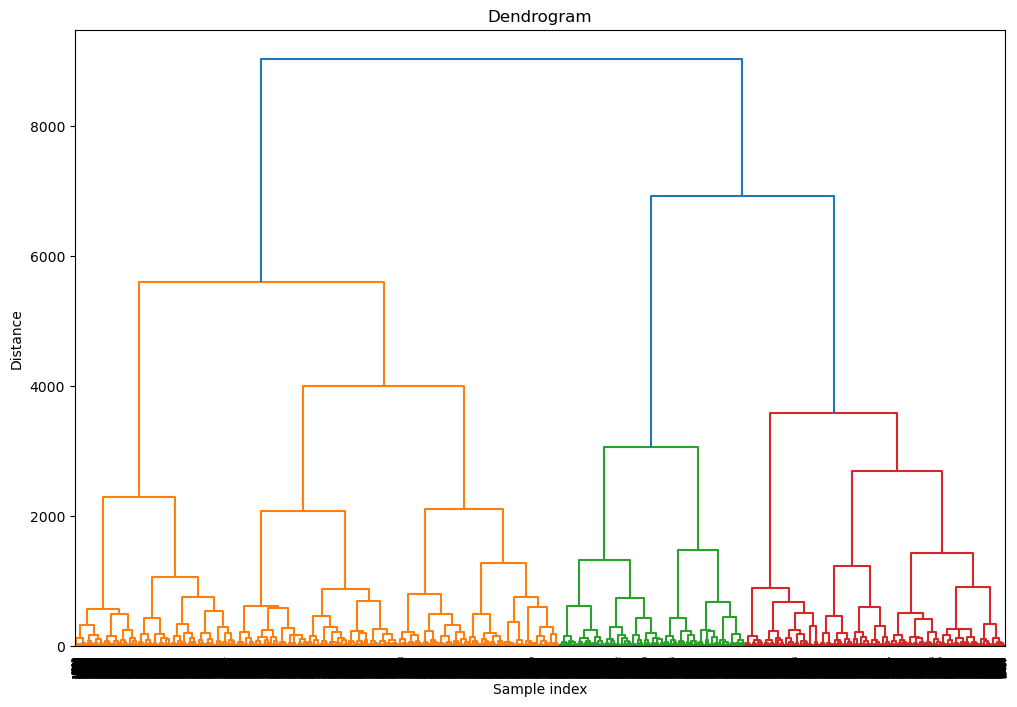

In [106]:

# Step 5: Apply hierarchical clustering on the t-SNE results
# Determine optimal number of clusters using dendrogram
plt.figure(figsize=(12, 8))
dendrogram = shc.dendrogram(shc.linkage(tsne_results, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()




In [107]:
# Based on the dendrogram, choose a reasonable number of clusters
n_clusters = 6  # Adjust based on dendrogram visualization
hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
sample_df['cluster'] = hierarchical.fit_predict(tsne_results)

In [108]:
sample_df

,pid,measured_date,enough_sleep,sleep_problems_bool,sleep_time_decimal,sleep_duration_decimal,wakeup_time_decimal,early_sleeper,normal_sleeper,late_sleeper,...,late_riser,sleep_time_sin,sleep_time_cos,wakeup_time_sin,wakeup_time_cos,satisfied,has_problems,tsne_x,tsne_y,cluster
541516,alqt1911104446,2019-11-14,False,False,21.750000,7.750000,5.500000,True,False,False,...,False,-0.555570,0.831470,0.991445,0.130526,False,False,38.842445,72.406883,0
303225,alqt180228595,2018-03-02,False,False,22.500000,6.083333,5.333333,False,True,False,...,False,-0.382683,0.923880,0.984808,0.173648,False,False,98.539597,-45.542709,1
444646,alqt190175841,2019-02-05,False,False,21.883333,8.616667,6.500000,True,False,False,...,False,-0.526214,0.850352,0.991445,-0.130526,False,False,32.731480,101.518402,0
82706,alqt150220506210082,2022-06-03,True,False,4.300000,7.066667,11.366667,False,False,False,...,True,0.902585,0.430511,0.165048,-0.986286,True,False,-54.193398,31.862408,2
668687,alqt2101165409,2021-02-07,False,False,22.000000,9.400000,7.400000,False,True,False,...,False,-0.500000,0.866025,0.933580,-0.358368,False,False,-46.114498,92.396111,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320366,alqt180533497,2018-07-05,False,False,22.000000,7.066667,5.666667,False,True,False,...,False,-0.500000,0.866025,0.996195,0.087156,False,False,88.671631,0.189813,1
693001,alqt210447177922,2021-05-01,True,False,23.316667,7.800000,7.116667,False,True,False,...,False,-0.177944,0.984041,0.957571,-0.288196,True,False,2.531323,29.589487,2
437797,alqt181273812,2018-12-19,False,False,1.100000,8.083333,9.183333,False,False,True,...,True,0.284015,0.958820,0.672367,-0.740218,False,False,-113.327164,-5.395692,2
734987,alqt211022187864,2021-10-17,False,True,23.500000,7.500000,7.000000,False,True,False,...,False,-0.130526,0.991445,0.965926,-0.258819,False,True,-1.430341,-39.055950,4


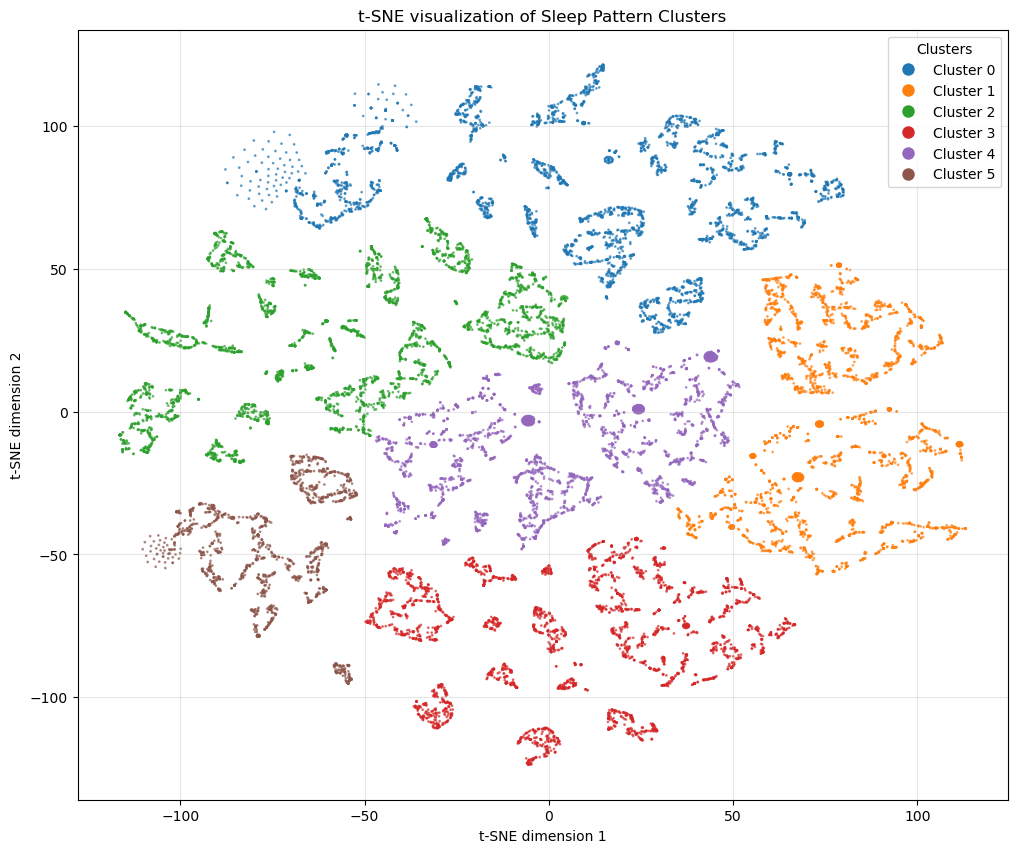

In [109]:
# Step 6: Visualize the clusters on t-SNE with a proper legend
plt.figure(figsize=(12, 10))

# Get unique clusters
unique_clusters = sorted(sample_df['cluster'].unique())

# Create a custom colormap with only the colors we need
from matplotlib.colors import ListedColormap
colors = plt.cm.tab10(np.linspace(0, 1, 10))  # Get the tab10 colors
cluster_colors = colors[unique_clusters]  # Select only colors for our clusters
custom_cmap = ListedColormap(cluster_colors)

# Create scatter plot
scatter = plt.scatter(
    sample_df['tsne_x'], 
    sample_df['tsne_y'], 
    c=sample_df['cluster'],
    cmap=custom_cmap, 
    alpha=0.6, 
    s=1
)

# Create legend with one entry per cluster
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], 
           label=f'Cluster {i}', markersize=10)
    for i in unique_clusters
]

plt.legend(handles=legend_elements, title="Clusters", loc="best")
plt.title('t-SNE visualization of Sleep Pattern Clusters')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.grid(True, alpha=0.3)
plt.show()

In [36]:

# Step 7: Analyze the characteristics of each cluster
cluster_analysis = sample_df.groupby('cluster').agg({
    'early_sleeper': 'mean',
    'normal_sleeper': 'mean',
    'late_sleeper': 'mean',
    'irregular_sleeper': 'mean',
    'short_sleep': 'mean',
    'normal_sleep': 'mean',
    'long_sleep': 'mean',
    'early_riser': 'mean',
    'normal_riser': 'mean',
    'late_riser': 'mean',
    'sleep_duration_decimal': 'mean',
    'sleep_time_decimal': 'mean',
    'wakeup_time_decimal': 'mean',
    'satisfied': 'mean',
    'has_problems': 'mean'
}).round(2)

print("\nCluster Analysis:")
display(cluster_analysis)



Cluster Analysis:


,early_sleeper,normal_sleeper,late_sleeper,irregular_sleeper,short_sleep,normal_sleep,long_sleep,early_riser,normal_riser,late_riser,sleep_duration_decimal,sleep_time_decimal,wakeup_time_decimal,satisfied,has_problems
cluster,,,,,,,,,,,,,,,
0,0.00,0.13,0.87,0.00,0.42,0.58,0.00,0.44,0.56,0.00,6.23,3.80,6.91,0.04,0.91
1,0.01,0.47,0.39,0.13,0.06,0.33,0.62,0.01,0.35,0.64,8.72,12.05,9.28,0.15,0.84
2,0.38,0.62,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,7.74,22.11,5.90,0.30,0.65
3,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,6.93,22.91,5.94,0.00,0.85
4,0.51,0.48,0.00,0.01,0.00,0.54,0.46,0.38,0.62,0.00,8.76,22.06,6.85,0.62,0.37
5,0.01,0.76,0.23,0.00,0.05,0.95,0.00,0.14,0.85,0.01,7.63,18.04,7.30,0.27,0.80


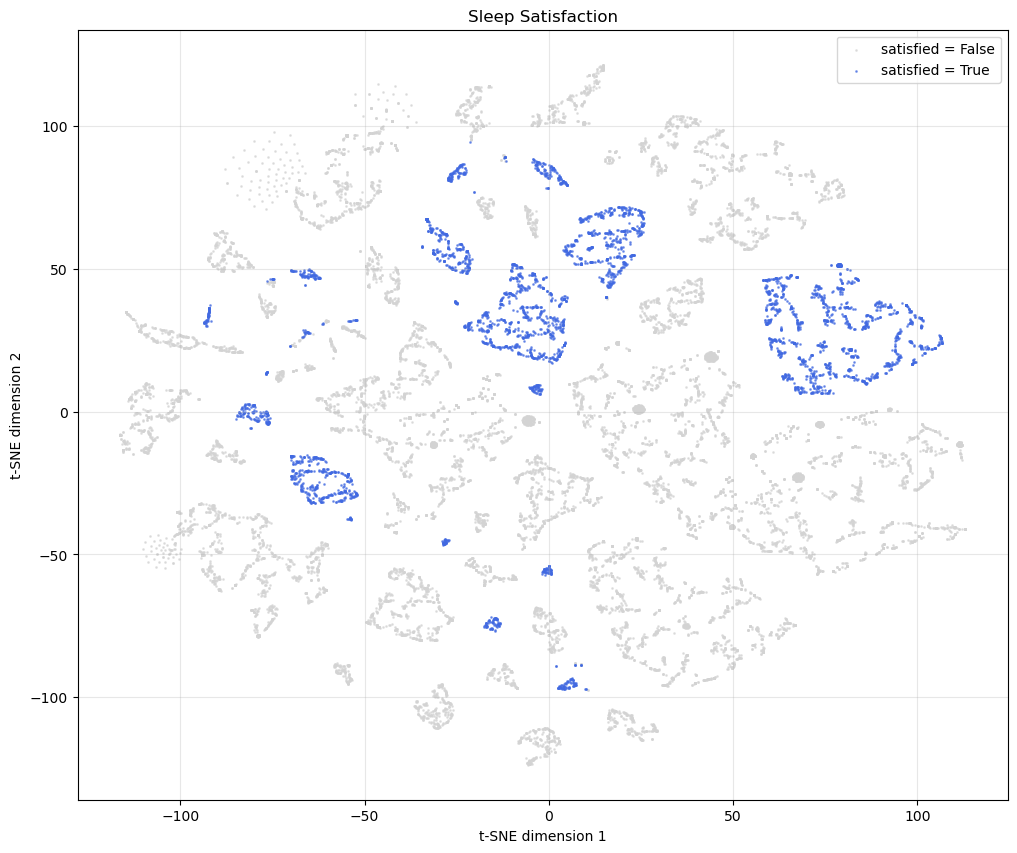

Statistics for satisfied:
True: 4352 (21.8%)
False: 15648 (78.2%)


In [110]:
def visualize_tsne_by_boolean(sample_df, boolean_column, title=None, s=1, alpha=0.6):
    """
    Visualize t-SNE results colored by a boolean column.
    
    Parameters:
    -----------
    sample_df : pandas DataFrame
        DataFrame containing 'tsne_x', 'tsne_y' columns and the boolean column
    boolean_column : str
        Name of the boolean column to use for coloring
    title : str, optional
        Plot title. If None, a default title is used.
    s : float, optional
        Marker size
    alpha : float, optional
        Transparency of the markers
    """
    # Validate the column exists and is boolean-like
    if boolean_column not in sample_df.columns:
        raise ValueError(f"Column '{boolean_column}' not found in the DataFrame")
    
    # Convert to boolean if it's not already
    is_bool = sample_df[boolean_column].map({True: True, False: False, 1: True, 0: False})
    
    # Create figure
    plt.figure(figsize=(12, 10))
    
    # Define colors for True and False
    true_color = 'royalblue'
    false_color = 'lightgray'
    
    # Plot False values first (as background)
    plt.scatter(
        sample_df.loc[~is_bool, 'tsne_x'],
        sample_df.loc[~is_bool, 'tsne_y'],
        color=false_color,
        alpha=alpha,
        s=s,
        label=f"{boolean_column} = False"
    )
    
    # Plot True values on top
    plt.scatter(
        sample_df.loc[is_bool, 'tsne_x'],
        sample_df.loc[is_bool, 'tsne_y'],
        color=true_color,
        alpha=alpha,
        s=s,
        label=f"{boolean_column} = True"
    )
    
    # Set title
    if title is None:
        title = f't-SNE Visualization by {boolean_column}'
    plt.title(title)
    
    # Add labels and legend
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Show plot
    plt.show()
    
    # Print some statistics
    true_count = is_bool.sum()
    false_count = (~is_bool).sum()
    total = len(is_bool)
    
    print(f"Statistics for {boolean_column}:")
    print(f"True: {true_count} ({true_count/total:.1%})")
    print(f"False: {false_count} ({false_count/total:.1%})")

# Example usage:
visualize_tsne_by_boolean(sample_df, 'satisfied', title='Sleep Satisfaction')


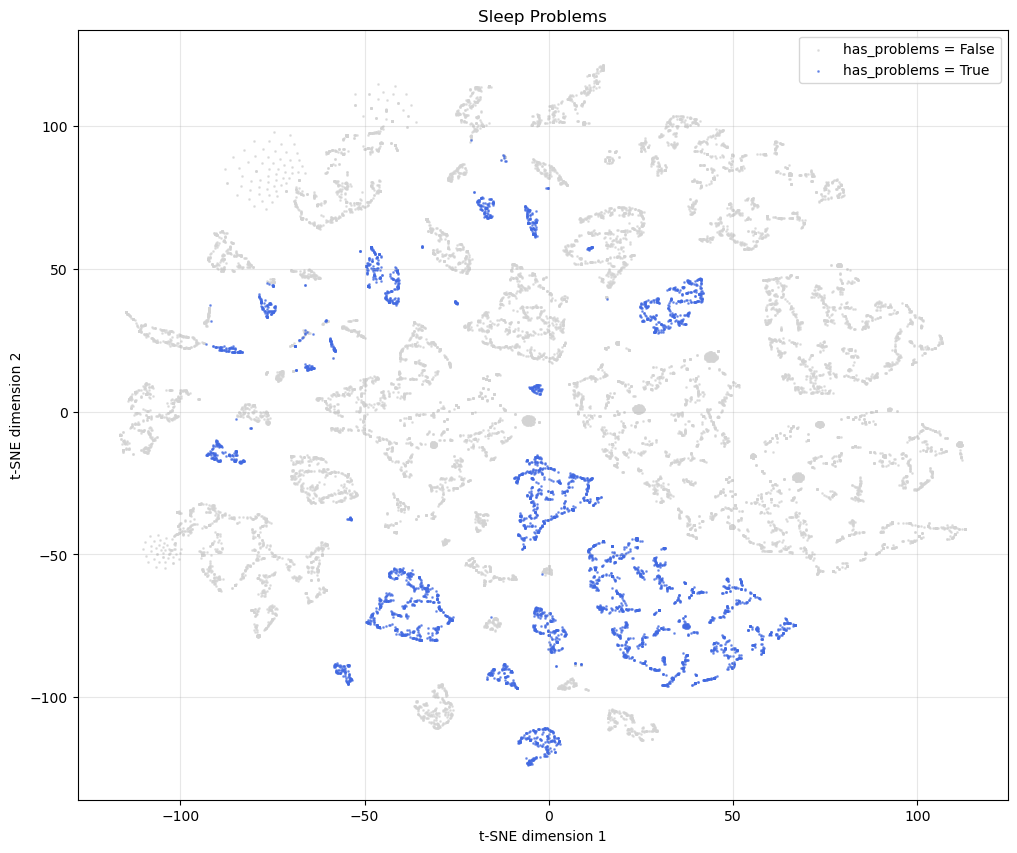

Statistics for has_problems:
True: 4772 (23.9%)
False: 15228 (76.1%)


In [111]:
visualize_tsne_by_boolean(sample_df, 'has_problems', title='Sleep Problems')


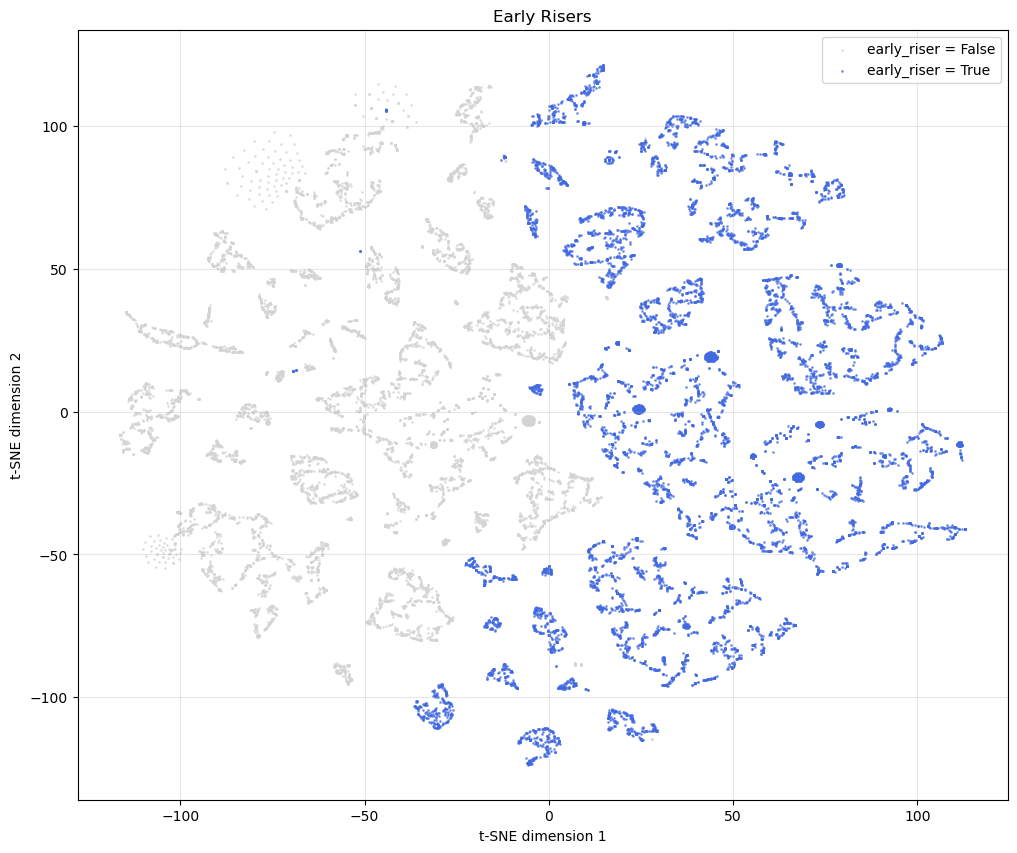

Statistics for early_riser:
True: 10824 (54.1%)
False: 9176 (45.9%)


In [112]:
visualize_tsne_by_boolean(sample_df, 'early_riser', title='Early Risers')

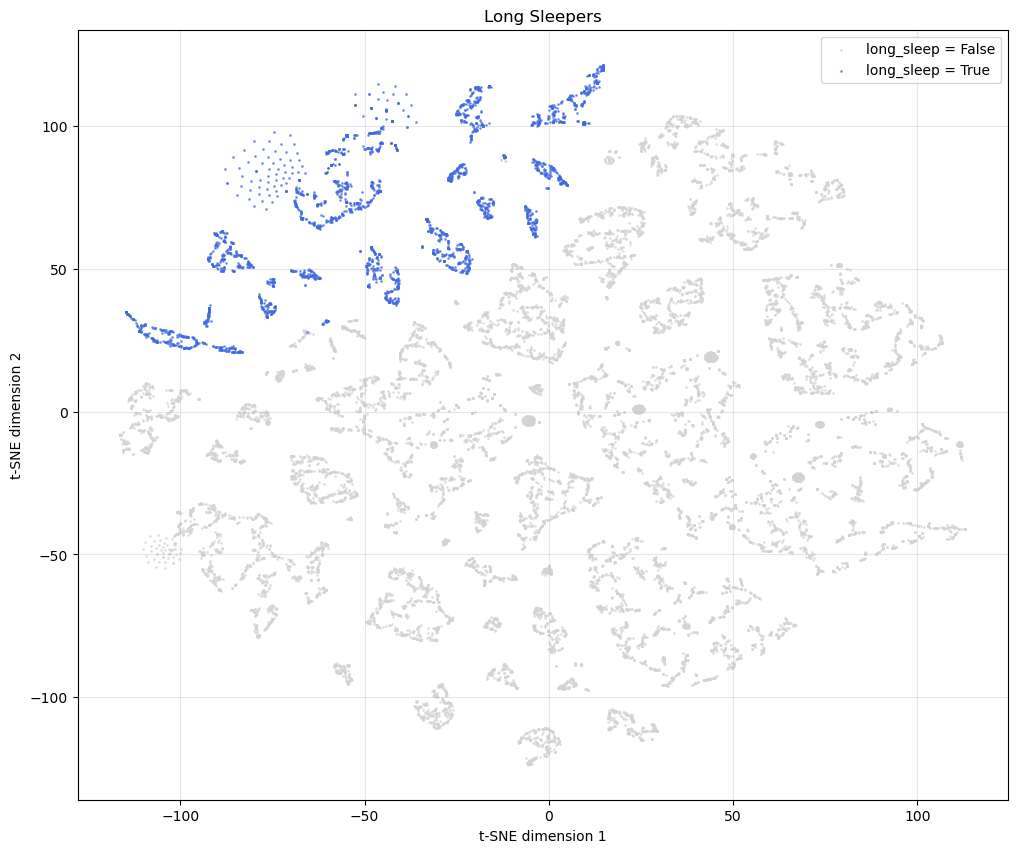

Statistics for long_sleep:
True: 3120 (15.6%)
False: 16880 (84.4%)


In [113]:
visualize_tsne_by_boolean(sample_df, 'long_sleep', title='Long Sleepers')

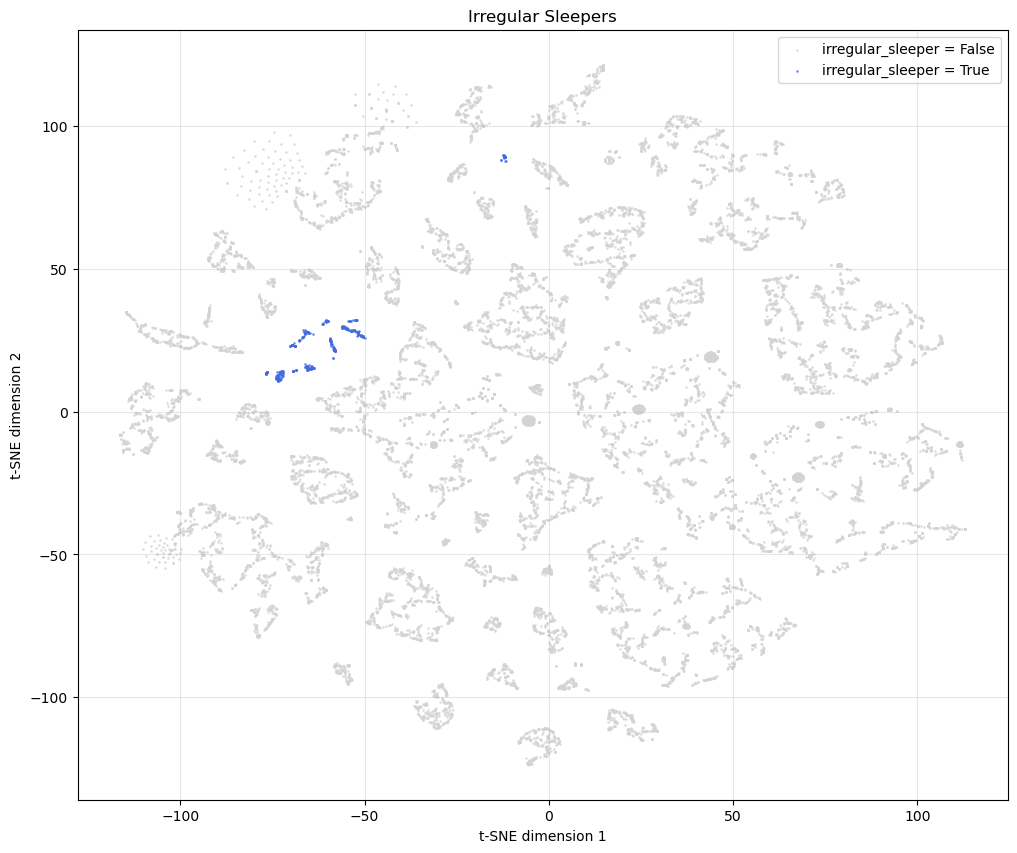

Statistics for irregular_sleeper:
True: 351 (1.8%)
False: 19649 (98.2%)


In [114]:
visualize_tsne_by_boolean(sample_df, 'irregular_sleeper', title='Irregular Sleepers')

In [115]:

# Step 7: Analyze the characteristics of each cluster
cluster_analysis = sample_df.groupby('cluster').agg({
    'early_sleeper': 'mean',
    'normal_sleeper': 'mean',
    'late_sleeper': 'mean',
    'irregular_sleeper': 'mean',
    'short_sleep': 'mean',
    'normal_sleep': 'mean',
    'long_sleep': 'mean',
    'early_riser': 'mean',
    'normal_riser': 'mean',
    'late_riser': 'mean',
    'sleep_duration_decimal': 'mean',
    'sleep_time_decimal': 'mean',
    'wakeup_time_decimal': 'mean',
    'satisfied': 'mean',
    'has_problems': 'mean'
}).round(2)

print("\nCluster Analysis:")
display(cluster_analysis)



Cluster Analysis:


,early_sleeper,normal_sleeper,late_sleeper,irregular_sleeper,short_sleep,normal_sleep,long_sleep,early_riser,normal_riser,late_riser,sleep_duration_decimal,sleep_time_decimal,wakeup_time_decimal,satisfied,has_problems
cluster,,,,,,,,,,,,,,,
0,0.81,0.18,0.00,0.01,0.00,0.57,0.43,0.71,0.29,0.00,8.58,21.50,6.15,0.21,0.15
1,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,6.98,22.85,5.92,0.39,0.00
2,0.01,0.64,0.27,0.08,0.04,0.61,0.35,0.00,0.56,0.44,8.55,15.53,8.70,0.36,0.18
3,0.00,0.58,0.41,0.00,0.30,0.70,0.00,0.84,0.16,0.00,6.40,13.78,6.15,0.06,0.76
4,0.00,0.96,0.04,0.00,0.04,0.96,0.00,0.46,0.54,0.00,7.77,22.21,6.92,0.03,0.19
5,0.00,0.00,1.00,0.00,0.06,0.94,0.00,0.00,1.00,0.00,7.10,0.73,7.90,0.26,0.07


In [ ]:
food_users = set(user_items_enhanced['pid'].unique())
print(f"Food users: {len(food_users)}")
sleep_users = set(user_sleep_df['pid'].unique())
print(f"Sleep users: {len(sleep_users)}")

common_users = food_users & sleep_users

# Filter the DataFrame to only include common users
user_items_df = user_items_enhanced[user_items_enhanced['pid'].isin(common_users)]
user_sleep_df = user_sleep_df[user_sleep_df['pid'].isin(common_users)]

print(f"Common users: {len(common_users)}")

Food users: 20985
Sleep users: 20191
Common users: 20191


In [155]:
user_sleep_df = create_sleep_archetypes(user_sleep_df)

In [156]:
user_sleep_df

,pid,measured_date,enough_sleep,sleep_problems_bool,sleep_time_decimal,sleep_duration_decimal,wakeup_time_decimal,early_sleeper,normal_sleeper,late_sleeper,...,long_sleep,early_riser,normal_riser,late_riser,sleep_time_sin,sleep_time_cos,wakeup_time_sin,wakeup_time_cos,satisfied,has_problems
182239,alqt150211047,2021-10-02,False,True,22.583333,7.916667,6.500000,False,True,False,...,False,True,False,False,-0.362438,0.932008,0.991445,-0.130526,False,True
182240,alqt150211047,2021-10-28,False,True,23.166667,8.966667,8.133333,False,True,False,...,False,False,True,False,-0.216440,0.976296,0.848048,-0.529919,False,True
182241,alqt150211047,2021-10-29,True,False,23.500000,9.500000,9.000000,False,True,False,...,True,False,False,True,-0.130526,0.991445,0.707107,-0.707107,True,False
182242,alqt150211047,2021-10-30,False,True,22.333333,8.916667,7.250000,False,True,False,...,False,False,True,False,-0.422618,0.906308,0.946930,-0.321439,False,True
182243,alqt150211047,2021-10-31,True,False,22.500000,9.050000,7.550000,False,True,False,...,True,False,True,False,-0.382683,0.923880,0.918791,-0.394744,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743962,alqt230941256543,2023-09-26,False,True,22.500000,8.416667,6.916667,False,True,False,...,False,True,False,False,-0.382683,0.923880,0.971342,-0.237686,False,True
744053,alqt230941256543,2023-09-27,False,True,2.250000,5.250000,7.500000,False,False,True,...,False,False,True,False,0.555570,0.831470,0.923880,-0.382683,False,True
744130,alqt230941256543,2023-09-28,False,True,0.166667,8.333333,8.500000,False,False,True,...,False,False,True,False,0.043619,0.999048,0.793353,-0.608761,False,True
744162,alqt230941256543,2023-09-29,False,True,22.500000,6.566667,5.066667,False,True,False,...,False,True,False,False,-0.382683,0.923880,0.970296,0.241922,False,True


# Graph Construction

In [ ]:
import networkx as nx

# Create a heterogeneous graph
G = nx.Graph()

# 1. Add user nodes
unique_users = set(user_sleep_df['pid'].unique())
for user_id in unique_users:
    G.add_node(user_id, type='user')

# 2. Add food item nodes
unique_foods = user_items_df['food_item'].unique()
for food in unique_foods:
    G.add_node(f"food_{food}", type='food')

# 3. Add time-specific food nodes (instead of general meal patterns)
# Define time bins (4-hour intervals)
time_bins = [(0, 4), (4, 10), (10, 16), (16, 22), (22, 24)]
time_bin_labels = ['late_night', 'morning', 'midday', 'evening', 'late_night']

# Create time-specific food nodes
for food in unique_foods:
    for time_label in time_bin_labels:
        G.add_node(f"food_{food}_{time_label}", type='food_time_specific')



# 4. Add sleep archetype nodes
sleep_archetypes = [
    'early_sleeper', 'normal_sleeper', 'late_sleeper', 'irregular_sleeper',
    'short_sleep', 'normal_sleep', 'long_sleep',
    'early_riser', 'normal_riser', 'late_riser',
    'satisfied', 'has_problems'
]
for archetype in sleep_archetypes:
    G.add_node(f"sleep_{archetype}", type='sleep_archetype')


# 5. Categorize food entries by time
def categorize_time(time_decimal):
    time_decimal = time_decimal % 24  # Ensure we're in 0-24 range
    for i, (start, end) in enumerate(time_bins):
        if start <= time_decimal < end:
            return time_bin_labels[i]
    return time_bin_labels[0]  # Default to late_night for edge cases


user_items_df['time_period'] = user_items_df['time_24h_decimal'].apply(categorize_time)


/var/folders/dv/lndb9rrs2kv2v5g8cyfyx0wr0000gn/T/ipykernel_33697/2717304175.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_items_df['time_period'] = user_items_df['time_24h_decimal'].apply(categorize_time)


In [214]:
# Display properties of the graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 38830
Number of edges: 0


In [215]:
food_time_counts = user_items_df.groupby(['pid', 'food_item', 'time_period']).size().reset_index(name='count')

food_counts = user_items_df.groupby(['pid', 'food_item']).size().reset_index(name='count')



In [173]:
user_food_totals = user_items_df.groupby('pid').size()

In [216]:

for _, row in food_time_counts.iterrows():
    user_id = row['pid']
    food = row['food_item']
    time_cat = row['time_period']
    count = row['count']
    
    # Normalize by user's total food count to get proportions
    total_user_foods = user_food_totals[user_id]
    weight = count / total_user_foods
    
    # Add edge to general food node (always exists)
    if G.has_edge(user_id, f"food_{food}"):
        # If edge exists, increment weight
        G[user_id][f"food_{food}"]['weight'] += weight
    else:
        # Create new edge
        G.add_edge(user_id, f"food_{food}", weight=weight, type='consumes')
    
    # # Add edge to time-specific food node (with weight)
    # G.add_edge(
    #     user_id, 
    #     f"food_{food}_{time_cat}", 
    #     weight=weight, 
    #     type='consumes_at_time'
    # )

In [217]:
# Display properties of the graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 38830
Number of edges: 1085982


In [219]:

# 8. Add user-to-sleep-archetype edges with weights (no threshold)
for user_id, user_data in sleep_augmented.groupby('pid'):
    # For each user, calculate their affinity to each sleep archetype
    for archetype in sleep_archetypes:
        if archetype in user_data.columns:
            # Calculate percentage of days this archetype applies
            affinity = user_data[archetype].mean()
            # Add edge with weight regardless of affinity value
            G.add_edge(user_id, f"sleep_{archetype}", weight=affinity, type='exhibits')


Walk iterations:   2%|▏         | 1/50 [16:09:46<791:59:15, 58186.84s/it]


In [220]:
# Display properties of the graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 38830
Number of edges: 1328274


In [184]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Extract unique food items and their embeddings
unique_foods = {}
for _, row in user_items_df.iterrows():
    if row['food_item'] not in unique_foods:
        unique_foods[row['food_item']] = row['embedding']

# Convert to lists for easier processing
food_names = list(unique_foods.keys())
food_embeddings = np.array(list(unique_foods.values()))

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(food_embeddings)

In [185]:
import pickle 

with open('food_similarity_matrix.pkl', 'wb') as f:
    pickle.dump(similarity_matrix, f)

In [186]:
with open("graph.pkl", 'wb') as f:
    pickle.dump(G, f)

In [209]:
similarity_matrix

array([[1.        , 0.37309856, 0.41010437, ..., 0.30570674, 0.27022298,
        0.43494262],
       [0.37309856, 1.        , 0.49670733, ..., 0.33965278, 0.27399879,
        0.3920892 ],
       [0.41010437, 0.49670733, 1.        , ..., 0.43598853, 0.31332528,
        0.36807865],
       ...,
       [0.30570674, 0.33965278, 0.43598853, ..., 1.        , 0.20279097,
        0.4380796 ],
       [0.27022298, 0.27399879, 0.31332528, ..., 0.20279097, 1.        ,
        0.30477305],
       [0.43494262, 0.3920892 , 0.36807865, ..., 0.4380796 , 0.30477305,
        1.        ]], shape=(2661, 2661))

In [223]:
food_similarity_edges = []

threshold = 0.75

s = 0
for i in range(len(food_names)):
    for j in range(i+1, len(food_names)):  # Start from i+1 to avoid duplicate edges
        similarity = similarity_matrix[i, j]
        if similarity > threshold:
            food_similarity_edges.append((
                f"food_{food_names[i]}",
                f"food_{food_names[j]}",
                {'weight': similarity, 'type': 'similar_to'}
            ))

# Add edges to graph
G.add_edges_from(food_similarity_edges)

print(f"Added {len(food_similarity_edges)} food similarity edges")

Added 2116 food similarity edges


In [224]:
# Display properties of the graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 38830
Number of edges: 1330390


### Graph Exploration

In [225]:
# Count nodes by type
node_types = {}
for node, data in G.nodes(data=True):
    node_type = data.get('type', 'unknown')
    node_types[node_type] = node_types.get(node_type, 0) + 1

print("Node types:")
for node_type, count in node_types.items():
    print(f"  {node_type}: {count}")

# Count edges by type
edge_types = {}
for u, v, data in G.edges(data=True):
    edge_type = data.get('type', 'unknown')
    edge_types[edge_type] = edge_types.get(edge_type, 0) + 1

print("\nEdge types:")
for edge_type, count in edge_types.items():
    print(f"  {edge_type}: {count}")

# Get degree distribution for user nodes
user_nodes = [node for node, data in G.nodes(data=True) if data.get('type') == 'user']
user_degrees = [G.degree(node) for node in user_nodes]

import numpy as np
print(f"\nUser node degree stats:")
print(f"  Min: {np.min(user_degrees)}")
print(f"  Max: {np.max(user_degrees)}")
print(f"  Mean: {np.mean(user_degrees):.2f}")
print(f"  Median: {np.median(user_degrees):.2f}")

Node types:
  user: 20191
  food: 2661
  food_time_specific: 15966
  sleep_archetype: 12

Edge types:
  consumes: 1085982
  exhibits: 242292
  similar_to: 2116

User node degree stats:
  Min: 13
  Max: 196
  Mean: 65.79
  Median: 64.00


# Clustering

## K-Means

In [228]:
import numpy as np
import scipy.sparse as sp
from sklearn.cluster import KMeans
import tqdm
import pickle

# Step 1: Create a bipartite adjacency matrix
# This represents connections between users and features (food, sleep, etc.)
print("Building adjacency matrix...")

# Get user nodes
user_nodes = [node for node, data in G.nodes(data=True) if data.get('type') == 'user']
print(f"Found {len(user_nodes)} user nodes")

# Get feature nodes (non-user nodes)
feature_nodes = [node for node, data in G.nodes(data=True) if data.get('type') != 'user']
print(f"Found {len(feature_nodes)} feature nodes")

# Create mappings for row and column indices
user_to_idx = {user: i for i, user in enumerate(user_nodes)}
feature_to_idx = {feature: i for i, feature in enumerate(feature_nodes)}

# Initialize sparse matrix data
row_indices = []
col_indices = []
values = []

# Fill matrix with edge data
for user in tqdm.tqdm(user_nodes, desc="Building adjacency matrix"):
    for neighbor in G.neighbors(user):
        # Skip edges between users
        if G.nodes[neighbor].get('type') == 'user':
            continue
            
        # Get indices
        user_idx = user_to_idx[user]
        feature_idx = feature_to_idx[neighbor]
        
        # Get edge weight
        weight = G[user][neighbor].get('weight', 1.0)
        
        # Add to sparse matrix data
        row_indices.append(user_idx)
        col_indices.append(feature_idx)
        values.append(weight)

# Create sparse matrix
adjacency = sp.csr_matrix((values, (row_indices, col_indices)), 
                          shape=(len(user_nodes), len(feature_nodes)))

print(f"Created adjacency matrix with shape {adjacency.shape}")

# Step 2: Normalize rows to account for different activity levels
print("Normalizing adjacency matrix...")
row_sums = adjacency.sum(axis=1).A.flatten()
# Avoid division by zero
row_sums[row_sums == 0] = 1
normalized_adjacency = adjacency.multiply(1 / row_sums[:, np.newaxis])

# Step 3: Calculate user similarity matrix
# For large matrices, we can project to lower dimension first
from sklearn.decomposition import TruncatedSVD

print("Performing dimensionality reduction...")
n_components = min(100, min(normalized_adjacency.shape) - 1)
svd = TruncatedSVD(n_components=n_components, random_state=42)
reduced_features = svd.fit_transform(normalized_adjacency)
print(f"Reduced to {n_components} dimensions, explained variance: {svd.explained_variance_ratio_.sum():.2%}")


Building adjacency matrix...
Found 20191 user nodes
Found 18639 feature nodes


Building adjacency matrix: 100%|██████████| 20191/20191 [00:01<00:00, 18588.84it/s]


Created adjacency matrix with shape (20191, 18639)
Normalizing adjacency matrix...
Performing dimensionality reduction...
Reduced to 100 dimensions, explained variance: 98.12%


In [270]:

# Step 4: Cluster the reduced features
print("Clustering users...")
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
clusters = kmeans.fit_predict(reduced_features)

# Step 5: Map back to user IDs
user_clusters = {user: cluster for user, cluster in zip(user_nodes, clusters)}

# Show cluster distribution
from collections import Counter
cluster_counts = Counter(user_clusters.values())
print("\nCluster distribution:")
for cluster_id, count in sorted(cluster_counts.items()):
    print(f"Cluster {cluster_id}: {count} users ({count/len(user_clusters)*100:.1f}%)")

# Save results
print("Saving clustering results...")
with open('user_clusters.pkl', 'wb') as f:
    pickle.dump(user_clusters, f)

# Step 6: Analyze what makes each cluster unique
print("\nAnalyzing cluster characteristics...")

# Get top features for each cluster
def get_top_features_per_cluster(cluster_id, top_n=20):
    # Get user indices for this cluster
    user_indices = [user_to_idx[user] for user, cluster in user_clusters.items() if cluster == cluster_id]
    
    # Get average feature values for this cluster
    cluster_features = adjacency[user_indices].mean(axis=0).A.flatten()
    
    # Get average feature values across all users
    all_features = adjacency.mean(axis=0).A.flatten()
    
    # Calculate the ratio of cluster average to global average
    # Add small epsilon to avoid division by zero
    feature_ratios = cluster_features / (all_features + 1e-10)
    
    # Get indices of top features
    top_indices = np.argsort(-feature_ratios)[:top_n]
    
    # Map back to feature names
    idx_to_feature = {i: feature for feature, i in feature_to_idx.items()}
    
    return [(idx_to_feature[i], feature_ratios[i]) for i in top_indices if feature_ratios[i] > 1.0]

# Show top distinctive features for each cluster
for cluster_id in sorted(cluster_counts.keys()):
    top_features = get_top_features_per_cluster(cluster_id)
    
    print(f"\nCluster {cluster_id} ({cluster_counts[cluster_id]} users) - Distinctive features:")
    for feature, ratio in top_features:
        print(f"  {feature}: {ratio:.2f}x average")

Clustering users...

Cluster distribution:
Cluster 0: 2793 users (13.8%)
Cluster 1: 6388 users (31.6%)
Cluster 2: 2716 users (13.5%)
Cluster 3: 3864 users (19.1%)
Cluster 4: 3294 users (16.3%)
Cluster 5: 1136 users (5.6%)
Saving clustering results...

Analyzing cluster characteristics...

Cluster 0 (2793 users) - Distinctive features:
  food_double chocolate chunk cookie: 7.23x average
  food_dymatize iso: 7.23x average
  food_jollof: 7.23x average
  food_green apple amino energy: 7.23x average
  food_cajun seasoning: 7.23x average
  food_pre jym: 7.23x average
  food_barukas: 7.23x average
  food_roast beef swiss sandwich: 7.23x average
  food_thinkthin high protein bar: 7.23x average
  food_wickles: 7.22x average
  food_optavia bar: 7.00x average
  food_licorice root tea: 6.76x average
  food_hershey's chocolate syrup: 6.72x average
  food_ginger lemon water: 6.42x average
  food_maitake mushroom: 6.27x average
  food_blue cheese salad dressing: 6.13x average
  food_ultima replenishe

In [275]:
user_items_df['kmeans_cluster_6'] = user_items_df['pid'].map(user_clusters)

/var/folders/dv/lndb9rrs2kv2v5g8cyfyx0wr0000gn/T/ipykernel_33697/4103126970.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_items_df['kmeans_cluster_6'] = user_items_df['pid'].map(user_clusters)


In [271]:
# Analyze sleep patterns specifically
print("\nAnalyzing sleep patterns by cluster...")

# Get sleep feature nodes
sleep_features = [node for node, data in G.nodes(data=True) 
                 if data.get('type') == 'sleep_archetype']
sleep_indices = [feature_to_idx[feature] for feature in sleep_features 
                if feature in feature_to_idx]

# For each cluster, calculate average sleep feature values
for cluster_id in sorted(cluster_counts.keys()):
    # Get user indices for this cluster
    user_indices = [user_to_idx[user] for user, cluster in user_clusters.items() 
                   if cluster == cluster_id]
    
    # Get average sleep feature values for this cluster
    cluster_sleep_features = adjacency[user_indices][:, sleep_indices].mean(axis=0).A.flatten()
    
    # Get average sleep feature values across all users
    all_sleep_features = adjacency[:, sleep_indices].mean(axis=0).A.flatten()
    
    # Calculate the ratio of cluster average to global average
    sleep_feature_ratios = cluster_sleep_features / (all_sleep_features + 1e-10)
    
    # Map indices back to feature names
    idx_to_feature = {feature_to_idx[feature]: feature for feature in sleep_features 
                      if feature in feature_to_idx}
    
    print(f"\nCluster {cluster_id} ({cluster_counts[cluster_id]} users) - Sleep patterns:")
    for i, ratio in sorted(enumerate(sleep_feature_ratios), key=lambda x: -x[1]):
        feature = idx_to_feature[sleep_indices[i]]
        print(f"  {feature}: {ratio:.2f}x average")


Analyzing sleep patterns by cluster...

Cluster 0 (2793 users) - Sleep patterns:
  sleep_early_sleeper: 4.18x average
  sleep_early_riser: 1.65x average
  sleep_long_sleep: 1.22x average
  sleep_normal_sleep: 1.01x average
  sleep_has_problems: 0.93x average
  sleep_satisfied: 0.85x average
  sleep_normal_sleeper: 0.47x average
  sleep_short_sleep: 0.46x average
  sleep_irregular_sleeper: 0.34x average
  sleep_normal_riser: 0.28x average
  sleep_late_riser: 0.13x average
  sleep_late_sleeper: 0.13x average

Cluster 1 (6388 users) - Sleep patterns:
  sleep_early_riser: 1.42x average
  sleep_normal_sleeper: 1.30x average
  sleep_short_sleep: 1.12x average
  sleep_has_problems: 1.12x average
  sleep_normal_sleep: 1.09x average
  sleep_early_sleeper: 0.64x average
  sleep_normal_riser: 0.57x average
  sleep_long_sleep: 0.53x average
  sleep_late_sleeper: 0.49x average
  sleep_late_riser: 0.27x average
  sleep_irregular_sleeper: 0.26x average
  sleep_satisfied: 0.18x average

Cluster 2 (27

In [277]:
def analyze_clusters(user_items_df, cluster_column, G, user_to_idx, feature_to_idx, adjacency, top_n=20):
    """
    Analyze clusters based on their distinctive features and sleep patterns.
    
    Parameters:
    -----------
    user_items_df : pandas DataFrame
        DataFrame containing user data with cluster assignments
    cluster_column : str
        Name of the column containing cluster assignments
    G : networkx Graph
        The graph containing nodes and edges
    user_to_idx : dict
        Mapping from user IDs to row indices in adjacency matrix
    feature_to_idx : dict
        Mapping from feature names to column indices in adjacency matrix
    adjacency : scipy sparse matrix
        Adjacency matrix representing user-feature connections
    top_n : int, optional
        Number of top features to display for each cluster
        
    Returns:
    --------
    dict
        Dictionary containing analysis results for each cluster
    """
    # Get unique users and their cluster assignments
    user_clusters = {}
    for pid, cluster in user_items_df[['pid', cluster_column]].drop_duplicates().values:
        if not pd.isna(cluster):  # Skip null values
            user_clusters[pid] = int(cluster)  # Ensure cluster ID is an integer
    
    # Count users in each cluster
    from collections import Counter
    cluster_counts = Counter(user_clusters.values())
    print(f"\nCluster distribution for {cluster_column}:")
    for cluster_id, count in sorted(cluster_counts.items()):
        print(f"Cluster {cluster_id}: {count} users ({count/len(user_clusters)*100:.1f}%)")
    
    # Store analysis results
    results = {'cluster_counts': cluster_counts, 'features': {}, 'sleep': {}}
    
    # Analyze distinctive features for each cluster
    print("\nAnalyzing distinctive features by cluster...")
    
    for cluster_id in sorted(cluster_counts.keys()):
        # Get user indices for this cluster
        user_indices = [user_to_idx[user] for user, cluster in user_clusters.items() 
                      if cluster == cluster_id and user in user_to_idx]
        
        if not user_indices:
            print(f"Warning: No users found in adjacency matrix for cluster {cluster_id}")
            continue
            
        # Get average feature values for this cluster
        cluster_features = adjacency[user_indices].mean(axis=0).A.flatten()
        
        # Get average feature values across all users
        all_features = adjacency.mean(axis=0).A.flatten()
        
        # Calculate the ratio of cluster average to global average
        feature_ratios = cluster_features / (all_features + 1e-10)
        
        # Get indices of top features
        top_indices = np.argsort(-feature_ratios)[:top_n]
        
        # Map back to feature names
        idx_to_feature = {i: feature for feature, i in feature_to_idx.items()}
        
        top_features = [(idx_to_feature[i], feature_ratios[i]) for i in top_indices if feature_ratios[i] > 1.0]
        results['features'][cluster_id] = top_features
        
        print(f"\nCluster {cluster_id} ({cluster_counts[cluster_id]} users) - Distinctive features:")
        for feature, ratio in top_features:
            print(f"  {feature}: {ratio:.2f}x average")
    
    # Analyze sleep patterns specifically
    print("\nAnalyzing sleep patterns by cluster...")
    
    # Get sleep feature nodes
    sleep_features = [node for node, data in G.nodes(data=True) 
                     if data.get('type') == 'sleep_archetype']
    sleep_indices = [feature_to_idx[feature] for feature in sleep_features 
                    if feature in feature_to_idx]
    
    for cluster_id in sorted(cluster_counts.keys()):
        # Get user indices for this cluster
        user_indices = [user_to_idx[user] for user, cluster in user_clusters.items() 
                       if cluster == cluster_id and user in user_to_idx]
        
        if not user_indices:
            continue
            
        # Get average sleep feature values for this cluster
        cluster_sleep_features = adjacency[user_indices][:, sleep_indices].mean(axis=0).A.flatten()
        
        # Get average sleep feature values across all users
        all_sleep_features = adjacency[:, sleep_indices].mean(axis=0).A.flatten()
        
        # Calculate the ratio of cluster average to global average
        sleep_feature_ratios = cluster_sleep_features / (all_sleep_features + 1e-10)
        
        # Map indices back to feature names
        idx_to_feature = {feature_to_idx[feature]: feature for feature in sleep_features 
                          if feature in feature_to_idx}
        
        sleep_patterns = [(idx_to_feature[sleep_indices[i]], ratio) 
                          for i, ratio in enumerate(sleep_feature_ratios)]
        sleep_patterns.sort(key=lambda x: x[1], reverse=True)
        results['sleep'][cluster_id] = sleep_patterns
        
        print(f"\nCluster {cluster_id} ({cluster_counts[cluster_id]} users) - Sleep patterns:")
        for feature, ratio in sleep_patterns:
            print(f"  {feature}: {ratio:.2f}x average")
    
    return results

# Example usage:
results = analyze_clusters(user_items_df, 'kmeans_cluster_6', G, user_to_idx, feature_to_idx, adjacency)


Cluster distribution for kmeans_cluster_6:
Cluster 0: 2793 users (13.8%)
Cluster 1: 6388 users (31.6%)
Cluster 2: 2716 users (13.5%)
Cluster 3: 3864 users (19.1%)
Cluster 4: 3294 users (16.3%)
Cluster 5: 1136 users (5.6%)

Analyzing distinctive features by cluster...

Cluster 0 (2793 users) - Distinctive features:
  food_double chocolate chunk cookie: 7.23x average
  food_dymatize iso: 7.23x average
  food_jollof: 7.23x average
  food_green apple amino energy: 7.23x average
  food_cajun seasoning: 7.23x average
  food_pre jym: 7.23x average
  food_barukas: 7.23x average
  food_roast beef swiss sandwich: 7.23x average
  food_thinkthin high protein bar: 7.23x average
  food_wickles: 7.22x average
  food_optavia bar: 7.00x average
  food_licorice root tea: 6.76x average
  food_hershey's chocolate syrup: 6.72x average
  food_ginger lemon water: 6.42x average
  food_maitake mushroom: 6.27x average
  food_blue cheese salad dressing: 6.13x average
  food_ultima replenisher: 5.92x average
  f

### Elbow

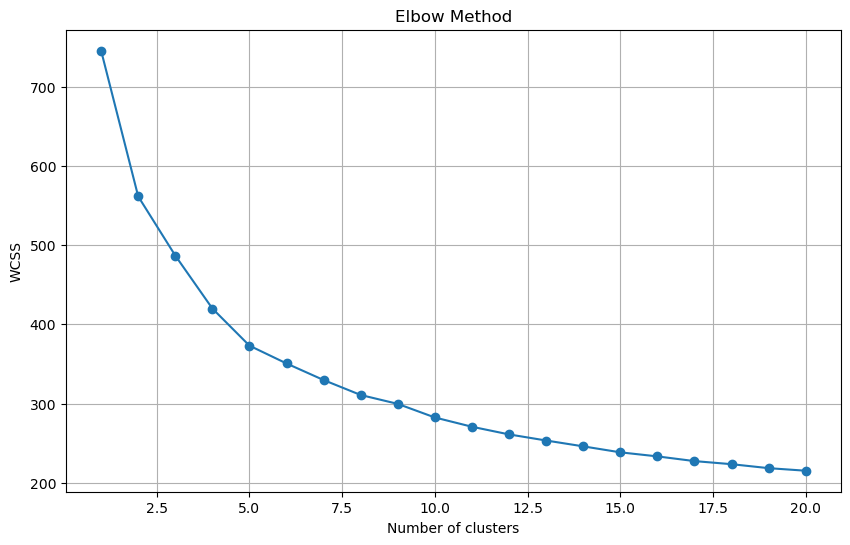

In [235]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
max_clusters = 20

for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(reduced_features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

### Silhouette

For n_clusters = 2, the silhouette score is 0.241
For n_clusters = 3, the silhouette score is 0.206
For n_clusters = 4, the silhouette score is 0.208
For n_clusters = 5, the silhouette score is 0.222
For n_clusters = 6, the silhouette score is 0.220
For n_clusters = 7, the silhouette score is 0.199
For n_clusters = 8, the silhouette score is 0.201
For n_clusters = 9, the silhouette score is 0.202
For n_clusters = 10, the silhouette score is 0.198
For n_clusters = 11, the silhouette score is 0.199
For n_clusters = 12, the silhouette score is 0.181
For n_clusters = 13, the silhouette score is 0.182
For n_clusters = 14, the silhouette score is 0.181


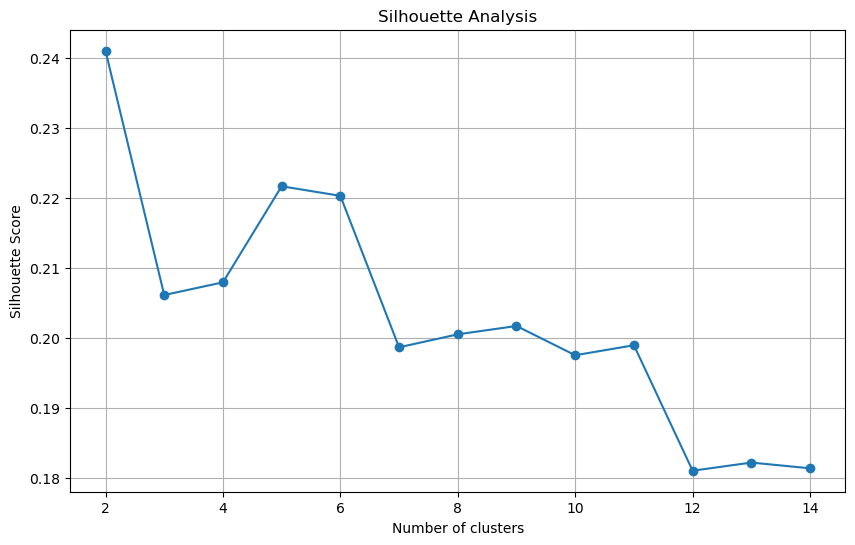

In [236]:
from sklearn.metrics import silhouette_score
import numpy as np

silhouette_scores = []
range_n_clusters = range(2, 15)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(reduced_features)
    silhouette_avg = silhouette_score(reduced_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Analysis')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

### Gap Statistic

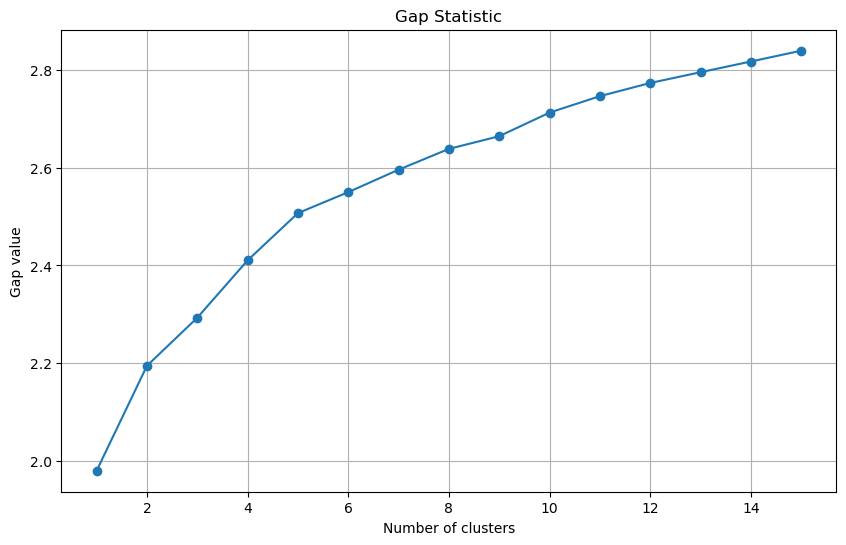

Optimal number of clusters: 15


In [237]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

def gap_statistic(data, k_max=15, n_refs=10):
    """Calculates the gap statistic for determining the optimal number of clusters"""
    # Generate reference datasets
    shape = data.shape
    
    # Sample size of reference distribution
    n_samples = shape[0]
    
    # Min and max of the data for sampling reference
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    
    # Results storage
    gaps = np.zeros(k_max)
    
    for k in range(1, k_max + 1):
        # Within-cluster dispersion for k clusters using actual data
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        Wk = kmeans.inertia_
        
        # Within-cluster dispersion for k clusters using reference data
        ref_dispersions = np.zeros(n_refs)
        
        for i in range(n_refs):
            # Generate uniform random reference
            random_data = np.random.random_sample(size=shape)
            # Scale to match the range of original data
            for j in range(shape[1]):
                random_data[:, j] = min_vals[j] + random_data[:, j] * (max_vals[j] - min_vals[j])
            
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(random_data)
            ref_dispersions[i] = kmeans.inertia_
        
        # Calculate gap statistic
        gap = np.log(np.mean(ref_dispersions)) - np.log(Wk)
        gaps[k-1] = gap
    
    return gaps

# Calculate gap statistic for reduced features
gaps = gap_statistic(reduced_features, k_max=15)

# Plot the gap statistic
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(gaps) + 1), gaps, marker='o')
plt.title('Gap Statistic')
plt.xlabel('Number of clusters')
plt.ylabel('Gap value')
plt.grid(True)
plt.show()

# Optimal number of clusters
optimal_k = np.argmax(gaps) + 1
print(f"Optimal number of clusters: {optimal_k}")

## DBSCAN

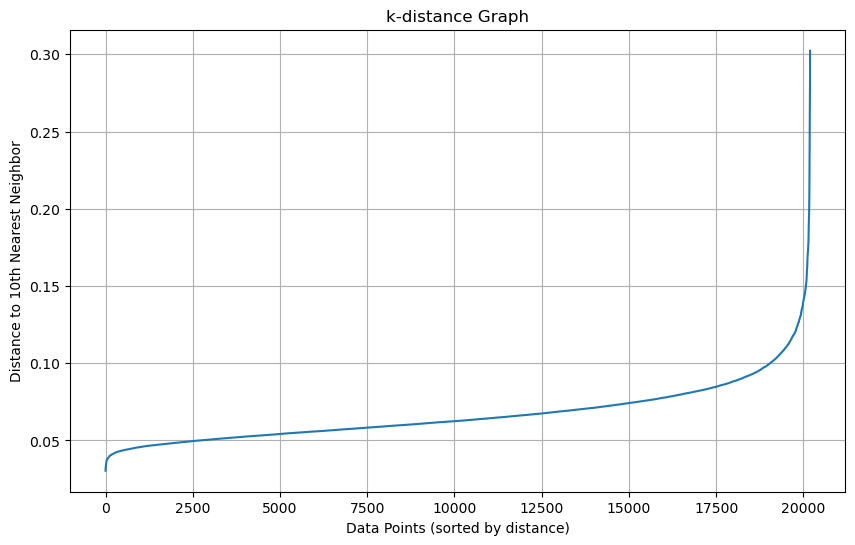

DBSCAN found 26 clusters and 14228 noise points
Epsilon: 0.05

Cluster distribution:
Cluster -1: 14228 users (70.5%)
Cluster 0: 4287 users (21.2%)
Cluster 1: 1400 users (6.9%)
Cluster 2: 14 users (0.1%)
Cluster 3: 15 users (0.1%)
Cluster 4: 19 users (0.1%)
Cluster 5: 36 users (0.2%)
Cluster 6: 20 users (0.1%)
Cluster 7: 11 users (0.1%)
Cluster 8: 17 users (0.1%)
Cluster 9: 10 users (0.0%)
Cluster 10: 14 users (0.1%)
Cluster 11: 12 users (0.1%)
Cluster 12: 10 users (0.0%)
Cluster 13: 6 users (0.0%)
Cluster 14: 7 users (0.0%)
Cluster 15: 9 users (0.0%)
Cluster 16: 9 users (0.0%)
Cluster 17: 5 users (0.0%)
Cluster 18: 10 users (0.0%)
Cluster 19: 8 users (0.0%)
Cluster 20: 6 users (0.0%)
Cluster 21: 11 users (0.1%)
Cluster 22: 6 users (0.0%)
Cluster 23: 6 users (0.0%)
Cluster 24: 5 users (0.0%)
Cluster 25: 10 users (0.0%)


In [248]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Estimate a good epsilon value (neighborhood radius)
nn = NearestNeighbors(n_neighbors=10)
nn.fit(reduced_features)
distances, indices = nn.kneighbors(reduced_features)

# Sort distances to the 10th nearest neighbor
distances = np.sort(distances[:, -1])

# Plot to find the "elbow"
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('k-distance Graph')
plt.xlabel('Data Points (sorted by distance)')
plt.ylabel('Distance to 10th Nearest Neighbor')
plt.grid(True)
plt.show()

# Choose epsilon based on the elbow in the plot
epsilon = float(input("Enter the epsilon value based on the elbow in the plot: "))

# Apply DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=10)
dbscan_labels = dbscan.fit_predict(reduced_features)

# Count the number of clusters (excluding noise points labeled as -1)
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"DBSCAN found {n_clusters} clusters and {(dbscan_labels == -1).sum()} noise points")
print(f"Epsilon: {epsilon}")

# Map back to user IDs
dbscan_clusters = {user: label for user, label in zip(user_nodes, dbscan_labels)}

# Show cluster distribution
from collections import Counter
cluster_counts = Counter(dbscan_clusters.values())
print("\nCluster distribution:")
for cluster_id, count in sorted(cluster_counts.items()):
    print(f"Cluster {cluster_id}: {count} users ({count/len(dbscan_clusters)*100:.1f}%)")

In [254]:
reduced_features.shape

(20191, 100)

## Agglomerative Clustering with Dynamic Tree Cut

Computing linkage for hierarchical clustering...


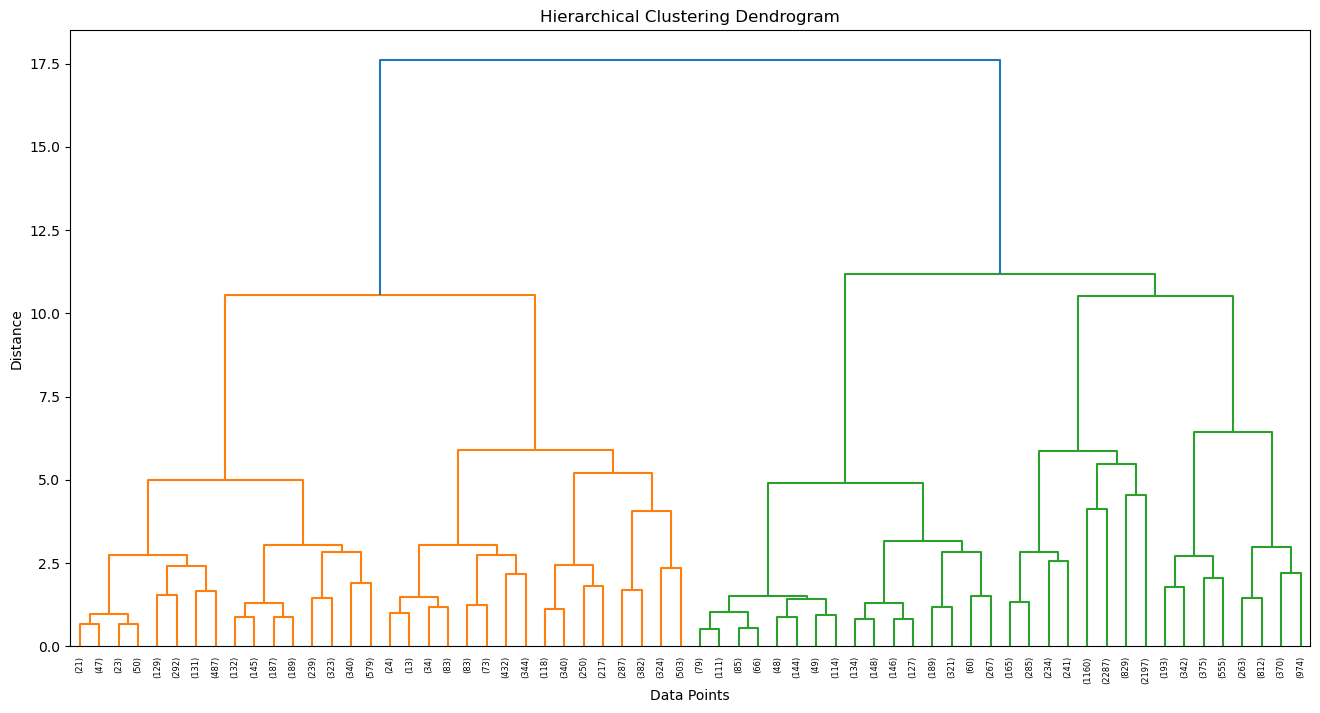

Distance threshold: 4.5
Hierarchical clustering found 13 clusters


In [267]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np

# Fix seed for reproducibility
np.random.seed(42)

# Compute linkage matrix
print("Computing linkage for hierarchical clustering...")
# For large datasets, sample to make computation feasible
sample_size = min(30000, reduced_features.shape[0])
if reduced_features.shape[0] > sample_size:
    indices = np.random.choice(reduced_features.shape[0], sample_size, replace=False)
    sample_features = reduced_features[indices]
else:
    sample_features = reduced_features
    indices = np.arange(reduced_features.shape[0])

Z = linkage(sample_features, method='ward')

# Plot dendrogram
plt.figure(figsize=(16, 8))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.axhline(y=200, color='r', linestyle='--')  # Adjust this threshold based on the dendrogram
plt.show()

# Choose a distance threshold based on the dendrogram
threshold = float(input("Enter the distance threshold from the dendrogram: "))
print(f"Distance threshold: {threshold}")

# Apply hierarchical clustering with the chosen threshold
hc = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=threshold,
    linkage='ward'
)
hc_labels = hc.fit_predict(reduced_features)

# Count the number of clusters
n_clusters = len(set(hc_labels))
print(f"Hierarchical clustering found {n_clusters} clusters")

# Map back to user IDs
hc_clusters = {user: label for user, label in zip(user_nodes, hc_labels)}

In [268]:
user_items_df['hc_cluster_4.5'] = user_items_df['pid'].map(hc_clusters)

/var/folders/dv/lndb9rrs2kv2v5g8cyfyx0wr0000gn/T/ipykernel_33697/2610024358.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_items_df['hc_cluster_4.5'] = user_items_df['pid'].map(hc_clusters)


In [269]:
user_items_df

,pid,food_type,original_logtime,log_date,time_24h_decimal,food_item,embedding,is_breakfast,is_lunch,is_dinner,is_late_night,time_period,gmm_cluster,hc_cluster_7.5,hc_cluster_12.5,hc_cluster_4.5
0,alqt150211047,b,2021-10-28 09:45:59,2021-10-28,9.766389,nespresso,"[-0.0067176544, -0.02788784, -0.012478107, 0.0...",True,False,False,False,morning,5,4,0,12
1,alqt150211047,f,2021-10-28 09:45:59,2021-10-28,9.766389,oatmeal,"[0.02143874, 0.021305107, 0.022809047, -0.0474...",True,False,False,False,morning,5,4,0,12
2,alqt150211047,b,2021-10-28 09:45:59,2021-10-28,9.766389,milk,"[0.034871925, 0.0069323634, -0.035317637, -0.0...",True,False,False,False,morning,5,4,0,12
3,alqt150211047,f,2021-10-28 11:57:00,2021-10-28,11.950000,eggplant,"[-0.0074746986, -0.072444454, -0.004489695, 0....",False,True,False,False,morning,5,4,0,12
4,alqt150211047,f,2021-10-28 11:57:00,2021-10-28,11.950000,lasagna,"[0.020851888, -0.050679404, 0.03552969, 0.0090...",False,True,False,False,morning,5,4,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3184274,alqt230941256543,b,2023-09-21 16:32:00,2023-09-21,16.533333,hibiscus tea,"[0.020282893, -0.030562764, -0.028167933, 0.01...",False,False,False,False,evening,5,3,1,2
3184275,alqt230941256543,f,2023-09-21 16:32:00,2023-09-21,16.533333,blueberry,"[0.015543392, -0.052315928, 0.0055276155, -0.0...",False,False,False,False,evening,5,3,1,2
3184276,alqt230941256543,f,2023-09-21 19:25:00,2023-09-21,19.416667,baked chicken,"[-0.0056958185, -0.014435805, 0.038879912, -0....",False,False,True,False,evening,5,3,1,2
3184277,alqt230941256543,f,2023-09-21 19:25:00,2023-09-21,19.416667,mashed potato,"[-0.0072039505, -0.0070065106, -0.008313367, -...",False,False,True,False,evening,5,3,1,2


## Gaussian Mixture Models

GMM with 1 components: BIC = -16478594.466685882
GMM with 2 components: BIC = -16943441.2190879
GMM with 3 components: BIC = -17160865.913471885
GMM with 4 components: BIC = -17289827.64114313
GMM with 5 components: BIC = -17365122.564784743
GMM with 6 components: BIC = -17374205.472278547
GMM with 7 components: BIC = -17408430.03562714
GMM with 8 components: BIC = -17405685.465998452
GMM with 9 components: BIC = -17395815.453436147


/Users/vince/miniforge3/envs/ds/lib/python3.12/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


GMM with 10 components: BIC = -17389516.930715013
GMM with 11 components: BIC = -17371559.32117398


/Users/vince/miniforge3/envs/ds/lib/python3.12/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


GMM with 12 components: BIC = -17356893.80483954
GMM with 13 components: BIC = -17339917.04726407
GMM with 14 components: BIC = -17306738.573125232
GMM with 15 components: BIC = -17277005.040300366


/Users/vince/miniforge3/envs/ds/lib/python3.12/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


GMM with 16 components: BIC = -17253508.12317032
GMM with 17 components: BIC = -17214919.08080259
GMM with 18 components: BIC = -17182722.651155695


/Users/vince/miniforge3/envs/ds/lib/python3.12/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


GMM with 19 components: BIC = -17148869.683512118


/Users/vince/miniforge3/envs/ds/lib/python3.12/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


GMM with 20 components: BIC = -17110498.37589334


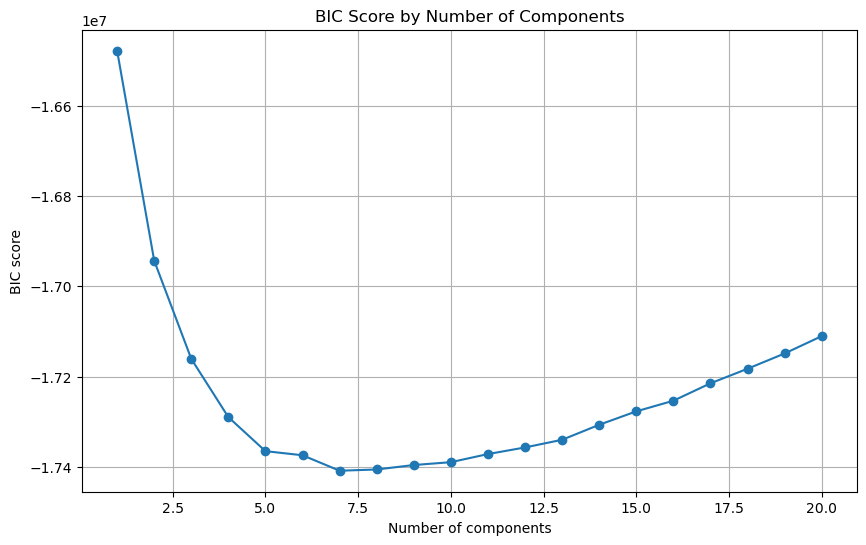

Optimal number of components: 7


In [255]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt

# Determine optimal number of components using BIC
bic_scores = []
max_components = 20

for n_components in range(1, max_components + 1):
    gmm = GaussianMixture(
        n_components=n_components,
        covariance_type='full',
        random_state=42,
        n_init=10
    )
    gmm.fit(reduced_features)
    bic_scores.append(gmm.bic(reduced_features))
    print(f"GMM with {n_components} components: BIC = {bic_scores[-1]}")

# Plot BIC scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_components + 1), bic_scores, marker='o')
plt.title('BIC Score by Number of Components')
plt.xlabel('Number of components')
plt.ylabel('BIC score')
plt.grid(True)
plt.show()

# Select optimal number of components (minimum BIC)
optimal_components = np.argmin(bic_scores) + 1
print(f"Optimal number of components: {optimal_components}")

# Fit the final model
gmm = GaussianMixture(
    n_components=optimal_components,
    covariance_type='full',
    random_state=42,
    n_init=10
)
gmm_labels = gmm.fit_predict(reduced_features)

# Map back to user IDs
gmm_clusters = {user: label for user, label in zip(user_nodes, gmm_labels)}

In [257]:
user_items_df['gmm_cluster'] = user_items_df['pid'].map(gmm_clusters)

/var/folders/dv/lndb9rrs2kv2v5g8cyfyx0wr0000gn/T/ipykernel_33697/1981395401.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_items_df['gmm_cluster'] = user_items_df['pid'].map(gmm_clusters)


In [259]:
user_items_df['gmm_cluster'].value_counts()

gmm_cluster
5    1217071
2     649857
1     373403
4     289891
6     246710
3     195476
0     104637
Name: count, dtype: int64

# Cluster Analysis

In [278]:
def analyze_clusters(user_items_df, cluster_column, G, user_to_idx, feature_to_idx, adjacency, top_n=20):
    """
    Analyze clusters based on their distinctive features and sleep patterns.
    
    Parameters:
    -----------
    user_items_df : pandas DataFrame
        DataFrame containing user data with cluster assignments
    cluster_column : str
        Name of the column containing cluster assignments
    G : networkx Graph
        The graph containing nodes and edges
    user_to_idx : dict
        Mapping from user IDs to row indices in adjacency matrix
    feature_to_idx : dict
        Mapping from feature names to column indices in adjacency matrix
    adjacency : scipy sparse matrix
        Adjacency matrix representing user-feature connections
    top_n : int, optional
        Number of top features to display for each cluster
        
    Returns:
    --------
    dict
        Dictionary containing analysis results for each cluster
    """
    # Get unique users and their cluster assignments
    user_clusters = {}
    for pid, cluster in user_items_df[['pid', cluster_column]].drop_duplicates().values:
        if not pd.isna(cluster):  # Skip null values
            user_clusters[pid] = int(cluster)  # Ensure cluster ID is an integer
    
    # Count users in each cluster
    from collections import Counter
    cluster_counts = Counter(user_clusters.values())
    print(f"\nCluster distribution for {cluster_column}:")
    for cluster_id, count in sorted(cluster_counts.items()):
        print(f"Cluster {cluster_id}: {count} users ({count/len(user_clusters)*100:.1f}%)")
    
    # Store analysis results
    results = {'cluster_counts': cluster_counts, 'features': {}, 'sleep': {}}
    
    # Analyze distinctive features for each cluster
    print("\nAnalyzing distinctive features by cluster...")
    
    for cluster_id in sorted(cluster_counts.keys()):
        # Get user indices for this cluster
        user_indices = [user_to_idx[user] for user, cluster in user_clusters.items() 
                      if cluster == cluster_id and user in user_to_idx]
        
        if not user_indices:
            print(f"Warning: No users found in adjacency matrix for cluster {cluster_id}")
            continue
            
        # Get average feature values for this cluster
        cluster_features = adjacency[user_indices].mean(axis=0).A.flatten()
        
        # Get average feature values across all users
        all_features = adjacency.mean(axis=0).A.flatten()
        
        # Calculate the ratio of cluster average to global average
        feature_ratios = cluster_features / (all_features + 1e-10)
        
        # Get indices of top features
        top_indices = np.argsort(-feature_ratios)[:top_n]
        
        # Map back to feature names
        idx_to_feature = {i: feature for feature, i in feature_to_idx.items()}
        
        top_features = [(idx_to_feature[i], feature_ratios[i]) for i in top_indices if feature_ratios[i] > 1.0]
        results['features'][cluster_id] = top_features
        
        print(f"\nCluster {cluster_id} ({cluster_counts[cluster_id]} users) - Distinctive features:")
        for feature, ratio in top_features:
            print(f"  {feature}: {ratio:.2f}x average")
    
    # Analyze sleep patterns specifically
    print("\nAnalyzing sleep patterns by cluster...")
    
    # Get sleep feature nodes
    sleep_features = [node for node, data in G.nodes(data=True) 
                     if data.get('type') == 'sleep_archetype']
    sleep_indices = [feature_to_idx[feature] for feature in sleep_features 
                    if feature in feature_to_idx]
    
    for cluster_id in sorted(cluster_counts.keys()):
        # Get user indices for this cluster
        user_indices = [user_to_idx[user] for user, cluster in user_clusters.items() 
                       if cluster == cluster_id and user in user_to_idx]
        
        if not user_indices:
            continue
            
        # Get average sleep feature values for this cluster
        cluster_sleep_features = adjacency[user_indices][:, sleep_indices].mean(axis=0).A.flatten()
        
        # Get average sleep feature values across all users
        all_sleep_features = adjacency[:, sleep_indices].mean(axis=0).A.flatten()
        
        # Calculate the ratio of cluster average to global average
        sleep_feature_ratios = cluster_sleep_features / (all_sleep_features + 1e-10)
        
        # Map indices back to feature names
        idx_to_feature = {feature_to_idx[feature]: feature for feature in sleep_features 
                          if feature in feature_to_idx}
        
        sleep_patterns = [(idx_to_feature[sleep_indices[i]], ratio) 
                          for i, ratio in enumerate(sleep_feature_ratios)]
        sleep_patterns.sort(key=lambda x: x[1], reverse=True)
        results['sleep'][cluster_id] = sleep_patterns
        
        print(f"\nCluster {cluster_id} ({cluster_counts[cluster_id]} users) - Sleep patterns:")
        for feature, ratio in sleep_patterns:
            print(f"  {feature}: {ratio:.2f}x average")
    
    return results

# Example usage:
results = analyze_clusters(user_items_df, 'kmeans_cluster_6', G, user_to_idx, feature_to_idx, adjacency)


Cluster distribution for kmeans_cluster_6:
Cluster 0: 2793 users (13.8%)
Cluster 1: 6388 users (31.6%)
Cluster 2: 2716 users (13.5%)
Cluster 3: 3864 users (19.1%)
Cluster 4: 3294 users (16.3%)
Cluster 5: 1136 users (5.6%)

Analyzing distinctive features by cluster...

Cluster 0 (2793 users) - Distinctive features:
  food_double chocolate chunk cookie: 7.23x average
  food_dymatize iso: 7.23x average
  food_jollof: 7.23x average
  food_green apple amino energy: 7.23x average
  food_cajun seasoning: 7.23x average
  food_pre jym: 7.23x average
  food_barukas: 7.23x average
  food_roast beef swiss sandwich: 7.23x average
  food_thinkthin high protein bar: 7.23x average
  food_wickles: 7.22x average
  food_optavia bar: 7.00x average
  food_licorice root tea: 6.76x average
  food_hershey's chocolate syrup: 6.72x average
  food_ginger lemon water: 6.42x average
  food_maitake mushroom: 6.27x average
  food_blue cheese salad dressing: 6.13x average
  food_ultima replenisher: 5.92x average
  f

In [279]:
# Analyze GMM clustering results n_components=7
gmm_results = analyze_clusters(user_items_df, 'gmm_cluster', G, user_to_idx, feature_to_idx, adjacency)



Cluster distribution for gmm_cluster:
Cluster 0: 1002 users (5.0%)
Cluster 1: 2214 users (11.0%)
Cluster 2: 4905 users (24.3%)
Cluster 3: 1369 users (6.8%)
Cluster 4: 1995 users (9.9%)
Cluster 5: 6837 users (33.9%)
Cluster 6: 1869 users (9.3%)

Analyzing distinctive features by cluster...

Cluster 0 (1002 users) - Distinctive features:
  food_jollof: 20.15x average
  food_realemon: 20.14x average
  food_fruit cordial: 18.84x average
  food_jugo verde: 14.11x average
  food_café: 12.15x average
  food_dextrose: 12.10x average
  food_skim milk: 11.69x average
  food_slimfast shake: 11.42x average
  food_dried fruits and nuts: 11.24x average
  food_desayuno: 11.09x average
  food_fika: 10.88x average
  food_supper: 10.18x average
  food_lunchtime: 9.54x average
  food_tonkotsu: 9.48x average
  food_breakfast shake: 9.19x average
  food_vollkornbrot: 9.04x average
  food_tuna fillet: 9.01x average
  food_murukku: 8.98x average
  food_vegetable breakfast burrito: 7.93x average
  food_laver

In [280]:
user_items_df

,pid,food_type,original_logtime,log_date,time_24h_decimal,food_item,embedding,is_breakfast,is_lunch,is_dinner,is_late_night,time_period,gmm_cluster,hc_cluster_7.5,hc_cluster_12.5,hc_cluster_4.5,kmeans_cluster_6
0,alqt150211047,b,2021-10-28 09:45:59,2021-10-28,9.766389,nespresso,"[-0.0067176544, -0.02788784, -0.012478107, 0.0...",True,False,False,False,morning,5,4,0,12,3
1,alqt150211047,f,2021-10-28 09:45:59,2021-10-28,9.766389,oatmeal,"[0.02143874, 0.021305107, 0.022809047, -0.0474...",True,False,False,False,morning,5,4,0,12,3
2,alqt150211047,b,2021-10-28 09:45:59,2021-10-28,9.766389,milk,"[0.034871925, 0.0069323634, -0.035317637, -0.0...",True,False,False,False,morning,5,4,0,12,3
3,alqt150211047,f,2021-10-28 11:57:00,2021-10-28,11.950000,eggplant,"[-0.0074746986, -0.072444454, -0.004489695, 0....",False,True,False,False,morning,5,4,0,12,3
4,alqt150211047,f,2021-10-28 11:57:00,2021-10-28,11.950000,lasagna,"[0.020851888, -0.050679404, 0.03552969, 0.0090...",False,True,False,False,morning,5,4,0,12,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3184274,alqt230941256543,b,2023-09-21 16:32:00,2023-09-21,16.533333,hibiscus tea,"[0.020282893, -0.030562764, -0.028167933, 0.01...",False,False,False,False,evening,5,3,1,2,3
3184275,alqt230941256543,f,2023-09-21 16:32:00,2023-09-21,16.533333,blueberry,"[0.015543392, -0.052315928, 0.0055276155, -0.0...",False,False,False,False,evening,5,3,1,2,3
3184276,alqt230941256543,f,2023-09-21 19:25:00,2023-09-21,19.416667,baked chicken,"[-0.0056958185, -0.014435805, 0.038879912, -0....",False,False,True,False,evening,5,3,1,2,3
3184277,alqt230941256543,f,2023-09-21 19:25:00,2023-09-21,19.416667,mashed potato,"[-0.0072039505, -0.0070065106, -0.008313367, -...",False,False,True,False,evening,5,3,1,2,3


In [281]:

# Analyze hierarchical clustering results
hc_12_results = analyze_clusters(user_items_df, 'hc_cluster_12.5', G, user_to_idx, feature_to_idx, adjacency)




Cluster distribution for hc_cluster_12.5:
Cluster 0: 13370 users (66.2%)
Cluster 1: 6821 users (33.8%)

Analyzing distinctive features by cluster...

Cluster 0 (13370 users) - Distinctive features:
  food_vollkornbrot: 1.51x average
  food_milchkaffee: 1.51x average
  food_vital drink: 1.51x average
  food_ginger lemon water: 1.51x average
  food_optavia bar: 1.51x average
  food_ultima replenisher: 1.51x average
  food_whole grain: 1.51x average
  food_double chocolate chunk cookie: 1.51x average
  food_friway glow: 1.51x average
  food_costco sample: 1.51x average
  food_einkorn: 1.51x average
  food_lenny & larry's: 1.51x average
  food_pack pyure: 1.51x average
  food_maple k: 1.51x average
  food_cow cream: 1.51x average
  food_sao: 1.51x average
  food_sunflower seeds: 1.51x average
  food_irish tea: 1.51x average
  food_vittoria dark chocochino: 1.51x average
  food_manioca: 1.51x average

Cluster 1 (6821 users) - Distinctive features:
  food_brottrunk: 2.96x average
  food_dri

In [282]:
hc_7_results = analyze_clusters(user_items_df, 'hc_cluster_7.5', G, user_to_idx, feature_to_idx, adjacency)


Cluster distribution for hc_cluster_7.5:
Cluster 0: 3884 users (19.2%)
Cluster 1: 3507 users (17.4%)
Cluster 2: 2088 users (10.3%)
Cluster 3: 3314 users (16.4%)
Cluster 4: 7398 users (36.6%)

Analyzing distinctive features by cluster...

Cluster 0 (3884 users) - Distinctive features:
  food_vital drink: 5.20x average
  food_whey hydrolysate isolate zero: 5.20x average
  food_kimchi jjigae: 5.20x average
  food_ideal protein triple chocolate: 5.20x average
  food_comida: 5.20x average
  food_ramyeon: 5.20x average
  food_coconut peanut butter bar: 5.20x average
  food_salchichón ibérico: 5.20x average
  food_eye of round roast: 5.20x average
  food_4c energy: 5.12x average
  food_plant protein bar: 4.58x average
  food_buchta: 4.38x average
  food_oat crunch cereal: 4.34x average
  food_sauvignon: 4.34x average
  food_fika: 4.27x average
  food_afternoon tea: 4.24x average
  food_chleba: 4.19x average
  food_guayusa tea: 4.13x average
  food_sugar syrup: 3.90x average
  food_jujube: 3.

In [283]:
hc_4_results = analyze_clusters(user_items_df, 'hc_cluster_4.5', G, user_to_idx, feature_to_idx, adjacency)


Cluster distribution for hc_cluster_4.5:
Cluster 0: 3447 users (17.1%)
Cluster 1: 1496 users (7.4%)
Cluster 2: 2134 users (10.6%)
Cluster 3: 1392 users (6.9%)
Cluster 4: 2419 users (12.0%)
Cluster 5: 1465 users (7.3%)
Cluster 6: 1086 users (5.4%)
Cluster 7: 925 users (4.6%)
Cluster 8: 2197 users (10.9%)
Cluster 9: 925 users (4.6%)
Cluster 10: 1180 users (5.8%)
Cluster 11: 696 users (3.4%)
Cluster 12: 829 users (4.1%)

Analyzing distinctive features by cluster...

Cluster 0 (3447 users) - Distinctive features:
  food_double chocolate chunk cookie: 5.86x average
  food_friway glow: 5.86x average
  food_pack pyure: 5.86x average
  food_maple k: 5.86x average
  food_sunflower seeds: 5.86x average
  food_skinny syrup foam topping: 5.86x average
  food_fat butter: 5.86x average
  food_green apple amino energy: 5.86x average
  food_finnish squeaky: 5.86x average
  food_basa loin: 5.86x average
  food_roast beef swiss sandwich: 5.86x average
  food_thorne protein: 5.86x average
  food_cow cre

In [208]:
import networkx as nx
import numpy as np
import random
from sklearn.cluster import KMeans
import tqdm
import pickle

def generate_walks(graph, nodes, num_walks=10, walk_length=10):
    """Generate random walks from each node"""
    walks = []
    
    for _ in tqdm.tqdm(range(num_walks), desc="Walk iteration"):
        # Shuffle nodes to randomize the walks
        nodes_copy = list(nodes)
        random.shuffle(nodes_copy)
        
        for node in tqdm.tqdm(nodes_copy, desc="Generating walks", leave=False):
            # Start a random walk from this node
            walk = [node]
            
            for _ in range(walk_length - 1):
                current = walk[-1]
                # Get neighbors of the current node
                neighbors = list(graph.neighbors(current))
                
                if not neighbors:
                    break
                
                # Get weights if available
                weights = [graph[current][neigh].get('weight', 1.0) for neigh in neighbors]
                total_weight = sum(weights)
                
                if total_weight == 0:
                    normalized_weights = [1.0/len(neighbors)] * len(neighbors)
                else:
                    normalized_weights = [w/total_weight for w in weights]
                
                # Choose next node based on weights
                next_node = random.choices(neighbors, weights=normalized_weights, k=1)[0]
                walk.append(next_node)
            
            walks.append(walk)
    
    return walks

# Create a subgraph with just users and their immediate neighbors for efficiency
print("Extracting user nodes...")
user_nodes = [node for node, data in G.nodes(data=True) if data.get('type') == 'user']
print(f"Found {len(user_nodes)} user nodes")

# Sample a subset of users if the graph is too large
max_users = 10000  # Adjust as needed
if len(user_nodes) > max_users:
    print(f"Sampling {max_users} users out of {len(user_nodes)}")
    user_sample = random.sample(user_nodes, max_users)
else:
    user_sample = user_nodes

# Create a relevant subgraph
print("Creating relevant subgraph...")
relevant_nodes = set(user_sample)

# Add immediate neighbors
for user in tqdm.tqdm(user_sample, desc="Finding relevant nodes"):
    relevant_nodes.update(G.neighbors(user))

# Create subgraph
subgraph = G.subgraph(relevant_nodes)
print(f"Created subgraph with {len(subgraph.nodes())} nodes and {len(subgraph.edges())} edges")

# Generate random walks
print("Generating random walks...")
walks = generate_walks(subgraph, user_sample, num_walks=10, walk_length=10)
print(f"Generated {len(walks)} walks")

# Convert walks to string format for Word2Vec
string_walks = [[str(node) for node in walk] for walk in walks]

# Train Word2Vec model using gensim
try:
    from gensim.models import Word2Vec
    
    print("Training Word2Vec model...")
    w2v_model = Word2Vec(
        string_walks,
        vector_size=64,
        window=5,
        min_count=1,
        sg=1,  # Skip-gram
        workers=4,
        epochs=5
    )
    
    # Extract user embeddings
    print("Extracting user embeddings...")
    user_embeddings = {}
    for user in tqdm.tqdm(user_sample, desc="Getting embeddings"):
        user_str = str(user)
        if user_str in w2v_model.wv:
            user_embeddings[user] = w2v_model.wv[user_str]
    
    print(f"Got embeddings for {len(user_embeddings)}/{len(user_sample)} users")
    
    # Convert to matrix for clustering
    user_ids = list(user_embeddings.keys())
    embedding_matrix = np.array([user_embeddings[user_id] for user_id in user_ids])
    
    # Apply K-means
    print("Applying K-means clustering...")
    kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(embedding_matrix)
    
    # Map back to user IDs
    user_clusters = {user_id: cluster for user_id, cluster in zip(user_ids, clusters)}
    
    # Save results
    print("Saving clustering results...")
    with open('user_clusters.pkl', 'wb') as f:
        pickle.dump(user_clusters, f)
    
    # Show cluster distribution
    from collections import Counter
    cluster_counts = Counter(user_clusters.values())
    print("\nCluster distribution:")
    for cluster_id, count in sorted(cluster_counts.items()):
        print(f"Cluster {cluster_id}: {count} users ({count/len(user_clusters)*100:.1f}%)")

except ImportError:
    print("Error importing gensim Word2Vec")
    
    # Alternative: use a simple co-occurrence matrix for embedding
    print("Falling back to co-occurrence-based clustering...")
    
    # Build co-occurrence matrix between users based on shared attributes
    user_set = set(user_sample)
    n_users = len(user_set)
    user_to_idx = {user: i for i, user in enumerate(user_sample)}
    
    # Initialize co-occurrence matrix
    cooc_matrix = np.zeros((n_users, n_users))
    
    # Fill matrix based on how many times users are in the same walk
    for walk in tqdm.tqdm(walks, desc="Building co-occurrence matrix"):
        # Get only users in this walk
        users_in_walk = [node for node in walk if node in user_set]
        
        # For each pair of users in walk, increment co-occurrence
        for i in range(len(users_in_walk)):
            for j in range(i+1, len(users_in_walk)):
                user1 = users_in_walk[i]
                user2 = users_in_walk[j]
                idx1 = user_to_idx[user1]
                idx2 = user_to_idx[user2]
                cooc_matrix[idx1, idx2] += 1
                cooc_matrix[idx2, idx1] += 1
    
    # Apply clustering to co-occurrence matrix
    print("Applying K-means clustering...")
    kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(cooc_matrix)
    
    # Map back to user IDs
    user_clusters = {user_id: cluster for user_id, cluster in zip(user_sample, clusters)}
    
    # Save results
    print("Saving clustering results...")
    with open('user_clusters.pkl', 'wb') as f:
        pickle.dump(user_clusters, f)
    
    # Show cluster distribution
    from collections import Counter
    cluster_counts = Counter(user_clusters.values())
    print("\nCluster distribution:")
    for cluster_id, count in sorted(cluster_counts.items()):
        print(f"Cluster {cluster_id}: {count} users ({count/len(user_clusters)*100:.1f}%)")

Extracting user nodes...
Found 20191 user nodes
Sampling 10000 users out of 20191
Creating relevant subgraph...



Finding relevant nodes: 100%|██████████| 10000/10000 [00:00<00:00, 138385.23it/s]


Created subgraph with 25410 nodes and 4890721 edges
Generating random walks...


Generated 100000 walks


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
import random
import collections
import tqdm
import numpy as np
from sklearn.cluster import SpectralClustering

def monte_carlo_user_similarity(G, n_walks=100, walk_length=10):
    user_nodes = [node for node, data in G.nodes(data=True) if data.get('type') == 'user']
    user_similarities = collections.defaultdict(lambda: collections.defaultdict(int))
    
    print(f"Running Monte Carlo with {n_walks} walks of length {walk_length} for {len(user_nodes)} users")
    
    # Main progress bar for walk iterations
    walk_pbar = tqdm.tqdm(total=n_walks, desc="Walk iterations")
    
    for walk_idx in range(n_walks):
        # Progress bar for users within each walk
        user_pbar = tqdm.tqdm(total=len(user_nodes), desc=f"Walk {walk_idx+1}/{n_walks}", 
                              leave=False, position=1)
        
        for start_user in user_nodes:
            # Start random walk from this user
            current = start_user
            visited_users = set()
            
            for step in range(walk_length):
                # Get neighbors weighted by edge weight
                neighbors = list(G.neighbors(current))
                if not neighbors:
                    break
                
                weights = [G[current][neigh].get('weight', 1.0) for neigh in neighbors]
                total_weight = sum(weights)
                if total_weight == 0:
                    normalized_weights = [1.0/len(neighbors)] * len(neighbors)
                else:
                    normalized_weights = [w/total_weight for w in weights]
                
                # Choose next node based on weights
                next_node = random.choices(neighbors, weights=normalized_weights, k=1)[0]
                current = next_node
                
                # If we hit another user, record it
                if G.nodes[current].get('type') == 'user' and current != start_user:
                    visited_users.add(current)
            
            # Update similarity counts
            for user in visited_users:
                user_similarities[start_user][user] += 1
            
            user_pbar.update(1)
        
        user_pbar.close()
        walk_pbar.update(1)
        
        # Print some stats every 10 walks
        if (walk_idx + 1) % 10 == 0:
            total_connections = sum(len(similarities) for similarities in user_similarities.values())
            avg_connections = total_connections / len(user_nodes) if user_nodes else 0
            print(f"\nWalk {walk_idx+1}: Found {total_connections} total connections, "
                  f"average {avg_connections:.2f} connections per user")
    
    walk_pbar.close()
    return user_similarities

# Run Monte Carlo simulation
print("Starting Monte Carlo simulation...")
user_similarities = monte_carlo_user_similarity(G, n_walks=50, walk_length=15)

# Convert to a similarity matrix
print("Building similarity matrix...")
user_nodes = [node for node, data in G.nodes(data=True) if data.get('type') == 'user']
n_users = len(user_nodes)
user_to_idx = {user: i for i, user in enumerate(user_nodes)}

similarity_matrix = np.zeros((n_users, n_users))

# Add another progress bar for building the similarity matrix
with tqdm.tqdm(total=len(user_similarities), desc="Building similarity matrix") as pbar:
    for user1, similarities in user_similarities.items():
        for user2, count in similarities.items():
            similarity_matrix[user_to_idx[user1], user_to_idx[user2]] = count
            similarity_matrix[user_to_idx[user2], user_to_idx[user1]] = count  # Make symmetric
        pbar.update(1)

# Optional: Save similarity matrix to avoid recomputing
print("Saving similarity matrix...")
np.save('user_similarity_matrix.npy', similarity_matrix)
print("Matrix saved to user_similarity_matrix.npy")

# Apply clustering to this similarity matrix
print(f"Applying spectral clustering with k={8}...")
spectral = SpectralClustering(n_clusters=8, affinity='precomputed', random_state=42, n_jobs=-1)
clusters = spectral.fit_predict(similarity_matrix)

# Map back to user IDs
monte_carlo_clusters = {user: cluster for user, cluster in zip(user_nodes, clusters)}

# Show cluster distribution
cluster_counts = collections.Counter(monte_carlo_clusters.values())
print("\nCluster distribution:")
for cluster_id, count in sorted(cluster_counts.items()):
    print(f"Cluster {cluster_id}: {count} users ({count/len(monte_carlo_clusters)*100:.1f}%)")

# Save results
import pickle
print("Saving clustering results...")
with open('user_clusters.pkl', 'wb') as f:
    pickle.dump(monte_carlo_clusters, f)
print("Results saved to user_clusters.pkl")

Starting Monte Carlo simulation...
Running Monte Carlo with 50 walks of length 15 for 20191 users


Walk iterations:   2%|▏         | 1/50 [18:28<15:05:06, 1108.29s/it]

KeyboardInterrupt: 